In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# **Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

import nndl.models.CNN as cnn
import nndl.models.CNNLSTM as clstm
import nndl.models.GRU as gru
import nndl.utils as utils
import time
import gc

# **Load data from localhost**

In [3]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# **Data Prep**

In [4]:
def data_prep(X,y,sub_sample,average,noise,channel_dropout,time_reverse):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if time_reverse != 0:
        mask = (torch.rand(total_X.shape[0]) >= time_reverse)
        X_reverse = torch.flip((total_X[mask]), [2])
        total_X = torch.cat((total_X, X_reverse))
        total_y = torch.cat((total_y, total_y[mask]))

        print(f'Shape of X after reverse {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')


    return total_X,total_y
    return total_X,total_y


def test_data_prep(X):

    total_X = None

    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 1e-4
batch_size = 200
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
channel_dropout = 0.2
time_reverse = 0.2
noise = True

'''
This was the old data prep.
The code below is just split up.
Split data, then split up X_train, X_val, X_test by subject and create dataloaders
Then dataprep and dataloader is performed for x_train etc
kept in case of error then can go back
i could have put them in lists
'''
'''
X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')
'''

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
#print(indices)
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
#print(split_idx)
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

person_train_valid, person_test = torch.Tensor(person_train_valid), torch.Tensor(person_test)
person_train, person_valid = person_train_valid[indices[:split_idx]], person_train_valid[indices[split_idx:]]

#check it matches
'''
index_zero = (indices == 0).nonzero(as_tuple=False) #index in indices that hold index 0 in X_train_valid and person_train_valid
print(index_zero)
print(indices[index_zero])
if index_zero > 1902: #in validation
  print(X_train_valid[0])
  print(X_train[index_zero - 1903])
  print(person_train[index_zero - 1903])
  print(person_train_valid[0])
else:
  print(X_train_valid[0])
  print(X_train[index_zero])
  print(person_train[index_zero])
  print(person_train_valid[0])
'''

################################################
#seperate X_train by subject using person_train
################################################

s_train = [[], [], [], [], [], [], [], [], []]
s_y_train = [[], [], [], [], [], [], [], [], []]
count_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_train, range(len(person_train))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_train[int(i[0])].append(X_train[j])
  s_y_train[int(i[0])].append(y_train[j])

  #for length check
  count_train[int(i[0])]+=1

print('subject counts: ', count_train)
print('subject count sum: ', sum(count_train))

#lebron
for (i, j, k) in zip(count_train, s_train, s_y_train):
  if i != len(j) or i != len(k):
    print("length issue")


print('\nsubject 0')
s0_train, s0_y_train = data_prep(torch.Tensor(np.asarray(s_train[0])), torch.Tensor(np.asarray(s_y_train[0])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 1')
s1_train, s1_y_train = data_prep(torch.Tensor(np.asarray(s_train[1])), torch.Tensor(np.asarray(s_y_train[1])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 2')
s2_train, s2_y_train = data_prep(torch.Tensor(np.asarray(s_train[2])), torch.Tensor(np.asarray(s_y_train[2])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 3')
s3_train, s3_y_train = data_prep(torch.Tensor(np.asarray(s_train[3])), torch.Tensor(np.asarray(s_y_train[3])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 4')
s4_train, s4_y_train = data_prep(torch.Tensor(np.asarray(s_train[4])), torch.Tensor(np.asarray(s_y_train[4])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 5')
s5_train, s5_y_train = data_prep(torch.Tensor(np.asarray(s_train[5])), torch.Tensor(np.asarray(s_y_train[5])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 6')
s6_train, s6_y_train = data_prep(torch.Tensor(np.asarray(s_train[6])), torch.Tensor(np.asarray(s_y_train[6])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 7')
s7_train, s7_y_train = data_prep(torch.Tensor(np.asarray(s_train[7])), torch.Tensor(np.asarray(s_y_train[7])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 8')
s8_train, s8_y_train = data_prep(torch.Tensor(np.asarray(s_train[8])), torch.Tensor(np.asarray(s_y_train[8])), subsample, average, noise, channel_dropout, time_reverse)

#############################################
#seperate X_val by subject using person_valid
#############################################
print(X_valid.shape)

s_valid = [[], [], [], [], [], [], [], [], []]
s_y_valid = [[], [], [], [], [], [], [], [], []]
count_val = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_valid, range(len(person_valid))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_valid[int(i[0])].append(X_valid[j])
  s_y_valid[int(i[0])].append(y_valid[j])

  #for length check
  count_val[int(i[0])]+=1

print('val counts: ', count_val)
print('val count sum: ', sum(count_val))

#lebron
for (i, j, k) in zip(count_val, s_valid, s_y_valid):
  if i != len(j) or i != len(k):
    print("length issue")

print('\nsubject 0')
s0_valid, s0_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[0])), torch.Tensor(np.asarray(s_y_valid[0])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 1')
s1_valid, s1_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[1])), torch.Tensor(np.asarray(s_y_valid[1])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 2')
s2_valid, s2_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[2])), torch.Tensor(np.asarray(s_y_valid[2])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 3')
s3_valid, s3_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[3])), torch.Tensor(np.asarray(s_y_valid[3])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 4')
s4_valid, s4_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[4])), torch.Tensor(np.asarray(s_y_valid[4])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 5')
s5_valid, s5_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[5])), torch.Tensor(np.asarray(s_y_valid[5])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 6')
s6_valid, s6_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[6])), torch.Tensor(np.asarray(s_y_valid[6])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 7')
s7_valid, s7_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[7])), torch.Tensor(np.asarray(s_y_valid[7])), subsample, average, noise, channel_dropout, time_reverse)
print('\nsubject 8')
s8_valid, s8_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[8])), torch.Tensor(np.asarray(s_y_valid[8])), subsample, average, noise, channel_dropout, time_reverse)

#############################################
#seperate X_test by subject using person_test
#############################################
print(X_test.shape)

s_test = [[], [], [], [], [], [], [], [], []]
s_y_test = [[], [], [], [], [], [], [], [], []]
count_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_test, range(len(person_test))):
  #i is a np.darray from person_test, i[0] gives us the subject
  #j is the index of i in person_test that corresponds to the index in X_test
  s_test[int(i[0])].append(X_test[j])
  s_y_test[int(i[0])].append(y_test[j])

  #for length check
  count_test[int(i[0])]+=1

print('test counts: ', count_test)
print('test count sum: ', sum(count_test))

#lebron length check
for (i, j, k) in zip(count_test, s_test, s_y_test):
  if i != len(j) or i != len(k):
    print("length issue")

#Look in my eyes, tell me your tale Do you see the road, the map to my soul? Look, tell me the signs whenever the smoke clear out of my face Am I picture-perfect or do I look fried?
print('\nsubject 0')
s0_test, s0_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[0]))), torch.Tensor(np.asarray(s_y_test[0]))
print('\nsubject 1')
s1_test, s1_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[1]))), torch.Tensor(np.asarray(s_y_test[1]))
print('\nsubject 2')
s2_test, s2_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[2]))), torch.Tensor(np.asarray(s_y_test[2]))
print('\nsubject 3')
s3_test, s3_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[3]))), torch.Tensor(np.asarray(s_y_test[3]))
print('\nsubject 4')
s4_test, s4_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[4]))), torch.Tensor(np.asarray(s_y_test[4]))
print('\nsubject 5')
s5_test, s5_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[5]))), torch.Tensor(np.asarray(s_y_test[5]))
print('\nsubject 6')
s6_test, s6_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[6]))), torch.Tensor(np.asarray(s_y_test[6]))
print('\nsubject 7')
s7_test, s7_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[7]))), torch.Tensor(np.asarray(s_y_test[7]))
print('\nsubject 8')
s8_test, s8_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[8]))), torch.Tensor(np.asarray(s_y_test[8]))

#############################
#Generate Subject DataLoader#
#############################

s0_train_loader = DataLoader(TensorDataset(s0_train, s0_y_train), batch_size=batch_size, shuffle=True)
s0_val_loader = DataLoader(TensorDataset(s0_valid, s0_y_valid), batch_size=batch_size, shuffle=True)
s0_test_loader = DataLoader(TensorDataset(s0_test, s0_y_test), batch_size=batch_size, shuffle=True)

s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train), batch_size=batch_size, shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid), batch_size=batch_size, shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test), batch_size=batch_size, shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train), batch_size=batch_size, shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid), batch_size=batch_size, shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test), batch_size=batch_size, shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train), batch_size=batch_size, shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid), batch_size=batch_size, shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test), batch_size=batch_size, shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train), batch_size=batch_size, shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid), batch_size=batch_size, shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test), batch_size=batch_size, shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train), batch_size=batch_size, shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid), batch_size=batch_size, shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test), batch_size=batch_size, shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train), batch_size=batch_size, shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid), batch_size=batch_size, shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test), batch_size=batch_size, shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train), batch_size=batch_size, shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid), batch_size=batch_size, shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test), batch_size=batch_size, shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train), batch_size=batch_size, shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid), batch_size=batch_size, shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test), batch_size=batch_size, shuffle=True)

subject_train_loader = [s0_train_loader, s1_train_loader, s2_train_loader, s3_train_loader, s4_train_loader, s5_train_loader, s6_train_loader, s7_train_loader,  s8_train_loader]
subject_val_loader = [s0_val_loader, s1_val_loader, s2_val_loader, s3_val_loader, s4_val_loader, s5_val_loader, s6_val_loader, s7_val_loader, s8_val_loader]
subject_test_loader = [s0_test_loader, s1_test_loader, s2_test_loader, s3_test_loader, s4_test_loader, s5_test_loader, s6_test_loader, s7_test_loader, s8_test_loader]


print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
subject counts:  [220, 211, 213, 211, 212, 209, 214, 204, 209]
subject count sum:  1903

subject 0
Shape of X after trimming: torch.Size([220, 22, 800])
Shape of X after maxpooling: torch.Size([220, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([440, 22, 400])
torch.Size([440, 1])
torch.Size([220, 1])
torch.Size([660, 1])
torch.Size([220, 1])
Shape of X after subsampling and concatenating: torch.Size([880, 22, 400])
Shape of Y: torch.Size([880])
Shape of X after channel dropout torch.Size([1760, 22, 400])
Shape of Y: torch.Size([1760])
Shape of X after reverse torch.Size([3161, 22, 400])
Shape of Y: torch.Size([3161])

subject 1
Shape of X after trimming: torch.Size([211, 22, 800])
Shape of X after maxpooling: torch.Size([211, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([422, 22, 400])
torch.Size([422, 1])
torch.Size([211, 1])
torch.Size([633, 1])
torch.Size([211, 1])
Shape of X after subsampling 

In [5]:
device = torch.device('cuda')

In [6]:
num_epochs = 50
num_trials = 20
start_time = time.time()

# **GRU**

In [7]:
params = utils.learn_hyperparameters(X_train=X_train,
                                     y_train=y_train,
                                     X_valid=X_valid,
                                     y_valid=y_valid,
                                     model_name='GRU',
                                     num_epochs=num_epochs,
                                     trials=num_trials)

[I 2024-03-12 18:49:21,628] A new study created in memory with name: no-name-a60ba10f-5876-424f-a025-c656e0d27e64


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              SGD
        Learning Rate:      0.0003388865649475426
        Weight Decay:       1.856183239996204e-05
        Momentum:           0.8672719897613165
    Model:                  GRU
        Dropout:            0.713930664721165
        Conv Kernel Size:   7
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.282, Val loss: 1.331
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.296, Val loss: 1.321
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.265, Val acc: 0.299, Val loss: 1.330
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.292, Val loss: 1.329


[I 2024-03-12 18:49:48,772] Trial 0 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              Adam
        Learning Rate:      0.0034192222229973384
        Weight Decay:       8.317015444528476e-05
    Model:                  GRU
        Dropout:            0.6240136457201514
        Conv Kernel Size:   6
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.291, Val loss: 1.308
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.324, Val acc: 0.352, Val loss: 1.357
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.366, Val acc: 0.356, Val loss: 1.180
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.417, Val acc: 0.415, Val loss: 1.206
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.430, Val loss: 1.144
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.495, Val acc: 0.430, Val loss: 1.108
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.527, Val acc: 0.446, Val loss: 1.108
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.558, Val acc: 0.467, Val loss: 1.097
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.597, Val acc: 0.452, Val loss: 1.207
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.458, Val loss: 1.490
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.668, Val acc: 0.529, Val loss: 1.097
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.699, Val acc: 0.530, Val loss: 1.042
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.490, Val loss: 0.957
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.759, Val acc: 0.523, Val loss: 1.257
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.788, Val acc: 0.519, Val loss: 1.671
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.813, Val acc: 0.519, Val loss: 1.310
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.823, Val acc: 0.520, Val loss: 1.308
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.521, Val loss: 1.350
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.536, Val loss: 1.577
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.525, Val loss: 1.559
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.513, Val loss: 1.324
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.522, Val loss: 1.225
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.550, Val loss: 1.320
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.539, Val loss: 1.863
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.554, Val loss: 1.887
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.561, Val loss: 2.036
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.970, Val acc: 0.557, Val loss: 2.037
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.559, Val loss: 2.160
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.549, Val loss: 2.321
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.568, Val loss: 2.481
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.563, Val loss: 2.360
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.562, Val loss: 2.565
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.565, Val loss: 2.399
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.562, Val loss: 2.171
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.551, Val loss: 2.327
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.556, Val loss: 2.360
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.562, Val loss: 2.388
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.564, Val loss: 2.466
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.558, Val loss: 2.397
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.562, Val loss: 2.443
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.560, Val loss: 2.414
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.558, Val loss: 2.409
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.560, Val loss: 2.413
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.565, Val loss: 2.381
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.560, Val loss: 2.529
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.555, Val loss: 2.482
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.993, Val acc: 0.563, Val loss: 2.567
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.993, Val acc: 0.565, Val loss: 2.582
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.566, Val loss: 2.523
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-12 18:55:29,899] Trial 1 finished with value: 0.5677936673164368 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0034192222229973384, 'weight_decay': 8.317015444528476e-05, 'momentum': 0.97727907756842, 'dropout': 0.6240136457201514, 'kernel': 6, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 256}. Best is trial 1 with value: 0.5677936673164368.


Train acc: 0.993, Val acc: 0.567, Val loss: 2.535
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.0008733951679425967
        Weight Decay:       4.963796681690632e-05
    Model:                  GRU
        Dropout:            0.5246641870106916
        Conv Kernel Size:   9
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.300, Val acc: 0.345, Val loss: 1.296
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.368, Val loss: 1.194
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.404, Val acc: 0.367, Val loss: 1.168
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.471, Val acc: 0.376, Val loss: 1.110
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.554, Val acc: 0.431, Val loss: 1.115
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.648, Val acc: 0.463, Val loss: 1.002
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.726, Val acc: 0.489, Val loss: 1.448
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.504, Val loss: 1.271
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.479, Val loss: 1.253
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.522, Val loss: 1.433
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.528, Val loss: 1.406
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.509, Val loss: 1.560
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.926, Val acc: 0.531, Val loss: 1.475
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.522, Val loss: 1.593
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.525, Val loss: 1.831
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.533, Val loss: 1.948
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.537, Val loss: 1.761
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.544, Val loss: 1.873
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.543, Val loss: 1.810
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.548, Val loss: 1.786
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.550, Val loss: 1.895
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.555, Val loss: 1.914
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.547, Val loss: 2.046
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.546, Val loss: 2.063
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.548, Val loss: 2.156
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.552, Val loss: 2.218
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.547, Val loss: 2.238
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.550, Val loss: 2.221
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.554, Val loss: 2.217
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.550, Val loss: 2.216
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.552, Val loss: 2.205
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.550, Val loss: 2.218
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.550, Val loss: 2.264
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.550, Val loss: 2.226
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.550, Val loss: 2.223
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.549, Val loss: 2.235
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.551, Val loss: 2.250
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.553, Val loss: 2.214
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.548, Val loss: 2.213
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.548, Val loss: 2.261
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.549, Val loss: 2.247
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.551, Val loss: 2.244
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.550, Val loss: 2.236
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.552, Val loss: 2.254
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.990, Val acc: 0.550, Val loss: 2.206
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.992, Val acc: 0.549, Val loss: 2.261
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.552, Val loss: 2.226
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.552, Val loss: 2.242
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.991, Val acc: 0.550, Val loss: 2.262
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-12 18:59:57,570] Trial 2 finished with value: 0.5545486211776733 and parameters: {'batch_size': 128, 'optimizer_name': 'NAdam', 'learning_rate': 0.0008733951679425967, 'weight_decay': 4.963796681690632e-05, 'momentum': 0.9491250511725386, 'dropout': 0.5246641870106916, 'kernel': 9, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 256}. Best is trial 1 with value: 0.5677936673164368.


Train acc: 0.991, Val acc: 0.550, Val loss: 2.243
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              NAdam
        Learning Rate:      0.00042675621593425955
        Weight Decay:       5.478928439367854e-06
    Model:                  GRU
        Dropout:            0.7623275284541657
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              32
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.308, Val loss: 1.392
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.266, Val acc: 0.326, Val loss: 1.377
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.290, Val acc: 0.330, Val loss: 1.402
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.334, Val acc: 0.418, Val loss: 1.266
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.374, Val acc: 0.444, Val loss: 1.267
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.434, Val loss: 1.191
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.429, Val acc: 0.470, Val loss: 1.141
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.460, Val acc: 0.469, Val loss: 1.155
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.473, Val acc: 0.477, Val loss: 1.126
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.495, Val acc: 0.497, Val loss: 1.097
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.505, Val loss: 1.058
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.533, Val acc: 0.487, Val loss: 1.113
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.548, Val acc: 0.501, Val loss: 1.117
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.560, Val acc: 0.539, Val loss: 1.016
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.578, Val acc: 0.513, Val loss: 1.045
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.589, Val acc: 0.550, Val loss: 1.054
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.603, Val acc: 0.560, Val loss: 0.969
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.611, Val acc: 0.565, Val loss: 1.008
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.619, Val acc: 0.550, Val loss: 1.067
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.577, Val loss: 0.998
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.566, Val loss: 0.956
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.654, Val acc: 0.581, Val loss: 0.941
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.663, Val acc: 0.576, Val loss: 0.959
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.586, Val loss: 1.011
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.578, Val loss: 0.991
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.684, Val acc: 0.564, Val loss: 1.056
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.687, Val acc: 0.595, Val loss: 1.000
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.698, Val acc: 0.596, Val loss: 1.053
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.700, Val acc: 0.596, Val loss: 1.015
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.704, Val acc: 0.594, Val loss: 0.988
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.711, Val acc: 0.597, Val loss: 1.008
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.722, Val acc: 0.588, Val loss: 1.127
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.723, Val acc: 0.583, Val loss: 1.001
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.739, Val acc: 0.601, Val loss: 0.953
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.749, Val acc: 0.602, Val loss: 0.946
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.752, Val acc: 0.603, Val loss: 0.979
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.752, Val acc: 0.603, Val loss: 0.972
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.754, Val acc: 0.608, Val loss: 0.980
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.758, Val acc: 0.610, Val loss: 0.978
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.759, Val acc: 0.603, Val loss: 0.972
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.758, Val acc: 0.603, Val loss: 0.962
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.764, Val acc: 0.611, Val loss: 0.948
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.607, Val loss: 1.005
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.763, Val acc: 0.616, Val loss: 0.990
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.613, Val loss: 0.978
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.763, Val acc: 0.613, Val loss: 0.992
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.611, Val loss: 0.986
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.769, Val acc: 0.611, Val loss: 0.984
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.767, Val acc: 0.616, Val loss: 0.975
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.617, Val loss: 0.980


[I 2024-03-12 19:05:33,582] Trial 3 finished with value: 0.6165911555290222 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.00042675621593425955, 'weight_decay': 5.478928439367854e-06, 'momentum': 0.8635547996591973, 'dropout': 0.7623275284541657, 'kernel': 9, 'pool_kernel': 4, 'depth': 32, 'hidden_dims': 128}. Best is trial 3 with value: 0.6165911555290222.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              Adamax
        Learning Rate:      0.0024126965264985004
        Weight Decay:       1.7080071414705121e-06
    Model:                  GRU
        Dropout:            0.676330971489219
        Conv Kernel Size:   8
        Pool Kernel Size:   3
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.330, Val loss: 1.332
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.373, Val loss: 1.168
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.432, Val acc: 0.470, Val loss: 1.051
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.534, Val acc: 0.511, Val loss: 0.960
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.559, Val loss: 0.952
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.685, Val acc: 0.563, Val loss: 1.074
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.734, Val acc: 0.563, Val loss: 1.192
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.568, Val loss: 1.187
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.801, Val acc: 0.588, Val loss: 1.071
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.825, Val acc: 0.587, Val loss: 1.071
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.571, Val loss: 1.206
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.590, Val loss: 1.099
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.573, Val loss: 1.214
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.586, Val loss: 1.314
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.564, Val loss: 1.451
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.568, Val loss: 1.170
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.939, Val acc: 0.585, Val loss: 1.327
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.589, Val loss: 1.386
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.585, Val loss: 1.387
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.584, Val loss: 1.413
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.586, Val loss: 1.444
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.594, Val loss: 1.476
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.963, Val acc: 0.591, Val loss: 1.435
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.594, Val loss: 1.523
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.969, Val acc: 0.586, Val loss: 1.528
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.591, Val loss: 1.578
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.596, Val loss: 1.640
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.593, Val loss: 1.601
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.593, Val loss: 1.575
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.593, Val loss: 1.620
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.594, Val loss: 1.625
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.593, Val loss: 1.626
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.592, Val loss: 1.596
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.591, Val loss: 1.591
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.596, Val loss: 1.619
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.594, Val loss: 1.579
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.594, Val loss: 1.665
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.596, Val loss: 1.661
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.598, Val loss: 1.640
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.595, Val loss: 1.656
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.594, Val loss: 1.652
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.592, Val loss: 1.637
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.598, Val loss: 1.717
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.596, Val loss: 1.664
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.596, Val loss: 1.617
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.597, Val loss: 1.626
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.595, Val loss: 1.648
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.595, Val loss: 1.659
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.596, Val loss: 1.681
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.596, Val loss: 1.629


[I 2024-03-12 19:13:16,244] Trial 4 finished with value: 0.5977692604064941 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.0024126965264985004, 'weight_decay': 1.7080071414705121e-06, 'momentum': 0.8560420590811709, 'dropout': 0.676330971489219, 'kernel': 8, 'pool_kernel': 3, 'depth': 128, 'hidden_dims': 256}. Best is trial 3 with value: 0.6165911555290222.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.0006340578309768757
        Weight Decay:       2.9306528247935178e-05
    Model:                  GRU
        Dropout:            0.7755516062038235
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.275, Val loss: 1.369
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.352, Val loss: 1.362
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.306, Val acc: 0.376, Val loss: 1.280
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.374, Val acc: 0.416, Val loss: 1.182
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.450, Val loss: 1.103
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.461, Val acc: 0.455, Val loss: 1.123
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.508, Val acc: 0.507, Val loss: 1.033
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.563, Val acc: 0.545, Val loss: 1.168
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.609, Val acc: 0.544, Val loss: 1.029
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.597, Val loss: 0.982
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.607, Val loss: 1.069
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.692, Val acc: 0.607, Val loss: 1.060
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.719, Val acc: 0.584, Val loss: 1.113
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.735, Val acc: 0.573, Val loss: 1.306
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.752, Val acc: 0.625, Val loss: 0.993
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.770, Val acc: 0.624, Val loss: 1.058
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.783, Val acc: 0.616, Val loss: 1.168
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.800, Val acc: 0.617, Val loss: 1.011
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.807, Val acc: 0.619, Val loss: 1.274
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.815, Val acc: 0.620, Val loss: 1.147
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.826, Val acc: 0.631, Val loss: 1.020
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.644, Val loss: 0.981
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.639, Val loss: 0.999
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.647, Val loss: 1.017
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.648, Val loss: 1.060
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.644, Val loss: 1.046
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.646, Val loss: 1.043
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.647, Val loss: 1.055
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.642, Val loss: 1.083
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.890, Val acc: 0.645, Val loss: 1.090
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.642, Val loss: 1.041
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.646, Val loss: 1.061
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.646, Val loss: 1.048
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.650, Val loss: 1.058
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.646, Val loss: 1.063
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.644, Val loss: 1.070
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.647, Val loss: 1.060
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.644, Val loss: 1.066
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.648, Val loss: 1.067
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.646, Val loss: 1.072
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.647, Val loss: 1.059
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.644, Val loss: 1.081
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.648, Val loss: 1.070
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.648, Val loss: 1.089
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.649, Val loss: 1.089
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.647, Val loss: 1.074
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.646, Val loss: 1.067
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.648, Val loss: 1.088
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.648, Val loss: 1.075
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.647, Val loss: 1.079


[I 2024-03-12 19:16:47,116] Trial 5 finished with value: 0.6500522494316101 and parameters: {'batch_size': 128, 'optimizer_name': 'NAdam', 'learning_rate': 0.0006340578309768757, 'weight_decay': 2.9306528247935178e-05, 'momentum': 0.8044207607855881, 'dropout': 0.7755516062038235, 'kernel': 9, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.0007911141833341353
        Weight Decay:       7.035429229221496e-06
    Model:                  GRU
        Dropout:            0.5585875672102958
        Conv Kernel Size:   10
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.288, Val acc: 0.348, Val loss: 1.275
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.351, Val acc: 0.397, Val loss: 1.121
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.411, Val acc: 0.432, Val loss: 1.067
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.506, Val acc: 0.489, Val loss: 1.033
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.611, Val acc: 0.525, Val loss: 1.120
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.704, Val acc: 0.513, Val loss: 1.406
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.770, Val acc: 0.524, Val loss: 1.196
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.564, Val loss: 1.273
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.551, Val loss: 1.135
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.573, Val loss: 1.307
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.559, Val loss: 1.461
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.544, Val loss: 1.603
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.926, Val acc: 0.569, Val loss: 1.633
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.562, Val loss: 1.743
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.539, Val loss: 1.549
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.964, Val acc: 0.562, Val loss: 1.624
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.973, Val acc: 0.567, Val loss: 1.697
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.565, Val loss: 1.842
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.570, Val loss: 1.857
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.569, Val loss: 1.847
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.562, Val loss: 1.890
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.570, Val loss: 1.996
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.564, Val loss: 2.039
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.982, Val acc: 0.565, Val loss: 2.028
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.563, Val loss: 2.158
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.571, Val loss: 2.180
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.573, Val loss: 2.155
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.566, Val loss: 2.145
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.564, Val loss: 2.124
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.567, Val loss: 2.144
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.569, Val loss: 2.122
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.571, Val loss: 2.104
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.564, Val loss: 2.141
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.565, Val loss: 2.163
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.563, Val loss: 2.142
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.567, Val loss: 2.138
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.566, Val loss: 2.146
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.566, Val loss: 2.190
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.567, Val loss: 2.143
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.566, Val loss: 2.170
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.566, Val loss: 2.180
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.566, Val loss: 2.174
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.564, Val loss: 2.144
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.564, Val loss: 2.161
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.566, Val loss: 2.178
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.565, Val loss: 2.161
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.566, Val loss: 2.175
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.565, Val loss: 2.148
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.564, Val loss: 2.177
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.566, Val loss: 2.164


[I 2024-03-12 19:21:02,103] Trial 6 finished with value: 0.5730219483375549 and parameters: {'batch_size': 128, 'optimizer_name': 'NAdam', 'learning_rate': 0.0007911141833341353, 'weight_decay': 7.035429229221496e-06, 'momentum': 0.9867284193136167, 'dropout': 0.5585875672102958, 'kernel': 10, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              SGD
        Learning Rate:      0.0006378620795386655
        Weight Decay:       3.637591159406742e-06
        Momentum:           0.967741884163884
    Model:                  GRU
        Dropout:            0.7297713084083015
        Conv Kernel Size:   8
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.311, Val loss: 1.354
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.306, Val loss: 1.354
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.298, Val loss: 1.346
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.281, Val acc: 0.278, Val loss: 1.342


[I 2024-03-12 19:21:18,146] Trial 7 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              SGD
        Learning Rate:      0.00502632515490646
        Weight Decay:       4.9348193793658295e-05
        Momentum:           0.9065492049161373
    Model:                  GRU
        Dropout:            0.6308063536200198
        Conv Kernel Size:   8
        Pool Kernel Size:   3
        Depth:              32
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.329, Val loss: 1.371
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.277, Val acc: 0.338, Val loss: 1.330
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.286, Val acc: 0.361, Val loss: 1.329
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.301, Val acc: 0.373, Val loss: 1.310
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.313, Val acc: 0.365, Val loss: 1.304
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.355, Val loss: 1.277
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.336, Val acc: 0.380, Val loss: 1.230
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.345, Val acc: 0.384, Val loss: 1.218
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.355, Val acc: 0.362, Val loss: 1.214
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.380, Val loss: 1.248
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.395, Val loss: 1.228
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.386, Val acc: 0.377, Val loss: 1.193
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.405, Val acc: 0.397, Val loss: 1.182
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.410, Val acc: 0.392, Val loss: 1.110
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.429, Val acc: 0.385, Val loss: 1.163
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.445, Val acc: 0.418, Val loss: 1.108
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.463, Val acc: 0.394, Val loss: 1.090
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.472, Val acc: 0.406, Val loss: 1.049
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.421, Val loss: 1.131
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.411, Val loss: 1.034
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.508, Val acc: 0.462, Val loss: 1.045
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.525, Val acc: 0.475, Val loss: 1.063
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.540, Val acc: 0.430, Val loss: 0.957
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.556, Val acc: 0.478, Val loss: 0.968
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.564, Val acc: 0.467, Val loss: 1.022
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.580, Val acc: 0.483, Val loss: 1.004
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.585, Val acc: 0.479, Val loss: 1.012
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.498, Val loss: 0.925
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.616, Val acc: 0.507, Val loss: 0.948
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.626, Val acc: 0.497, Val loss: 0.885
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.636, Val acc: 0.491, Val loss: 0.994
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.640, Val acc: 0.509, Val loss: 0.978
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.650, Val acc: 0.519, Val loss: 1.042
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.524, Val loss: 0.929
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.538, Val loss: 1.009
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.536, Val loss: 0.898
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.540, Val loss: 1.003
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.690, Val acc: 0.528, Val loss: 1.000
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.694, Val acc: 0.514, Val loss: 1.008
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.697, Val acc: 0.551, Val loss: 1.030
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.707, Val acc: 0.518, Val loss: 1.032
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.545, Val loss: 0.926
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.741, Val acc: 0.555, Val loss: 0.928
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.745, Val acc: 0.559, Val loss: 0.909
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.746, Val acc: 0.557, Val loss: 0.899
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.749, Val acc: 0.552, Val loss: 0.963
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.756, Val acc: 0.560, Val loss: 0.936
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.755, Val acc: 0.550, Val loss: 0.914
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.757, Val acc: 0.566, Val loss: 0.940
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.758, Val acc: 0.556, Val loss: 0.940


[I 2024-03-12 19:24:16,625] Trial 8 finished with value: 0.5657023191452026 and parameters: {'batch_size': 128, 'optimizer_name': 'SGD', 'learning_rate': 0.00502632515490646, 'weight_decay': 4.9348193793658295e-05, 'momentum': 0.9065492049161373, 'dropout': 0.6308063536200198, 'kernel': 8, 'pool_kernel': 3, 'depth': 32, 'hidden_dims': 128}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.00021550099588446534
        Weight Decay:       8.772007212034564e-06
    Model:                  GRU
        Dropout:            0.5195303226393575
        Conv Kernel Size:   6
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.314, Val loss: 1.343
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.287, Val acc: 0.316, Val loss: 1.356
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.306, Val acc: 0.340, Val loss: 1.332
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.324, Val loss: 1.305
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.366, Val loss: 1.287
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.342, Val loss: 1.274
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.371, Val acc: 0.365, Val loss: 1.233
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.389, Val acc: 0.356, Val loss: 1.228
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.364, Val loss: 1.239
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.360, Val loss: 1.199
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.434, Val acc: 0.353, Val loss: 1.237
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.363, Val loss: 1.218
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.365, Val loss: 1.155
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.486, Val acc: 0.362, Val loss: 1.162
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.506, Val acc: 0.351, Val loss: 1.181
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.523, Val acc: 0.352, Val loss: 1.160
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.371, Val loss: 1.192
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.556, Val acc: 0.365, Val loss: 1.180
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.360, Val loss: 1.124
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.594, Val acc: 0.378, Val loss: 1.096
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.609, Val acc: 0.364, Val loss: 1.211
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.628, Val acc: 0.371, Val loss: 1.134
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.390, Val loss: 1.204
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.661, Val acc: 0.384, Val loss: 1.207
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.381, Val loss: 1.121
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.690, Val acc: 0.384, Val loss: 1.211
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.702, Val acc: 0.393, Val loss: 1.258
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.397, Val loss: 1.208
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.718, Val acc: 0.400, Val loss: 1.200
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.738, Val acc: 0.394, Val loss: 1.204
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.748, Val acc: 0.407, Val loss: 1.342
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.767, Val acc: 0.408, Val loss: 1.269
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.771, Val acc: 0.407, Val loss: 1.281
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.404, Val loss: 1.263
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.406, Val loss: 1.312
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.780, Val acc: 0.406, Val loss: 1.277
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.780, Val acc: 0.403, Val loss: 1.293
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.786, Val acc: 0.407, Val loss: 1.297
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.786, Val acc: 0.404, Val loss: 1.282
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.788, Val acc: 0.402, Val loss: 1.347
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.785, Val acc: 0.402, Val loss: 1.307
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.790, Val acc: 0.405, Val loss: 1.334
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.793, Val acc: 0.402, Val loss: 1.339
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.403, Val loss: 1.346
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.407, Val loss: 1.339
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.793, Val acc: 0.402, Val loss: 1.344
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.403, Val loss: 1.338
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.796, Val acc: 0.404, Val loss: 1.334
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.793, Val acc: 0.404, Val loss: 1.341
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.406, Val loss: 1.346


[I 2024-03-12 19:27:28,033] Trial 9 finished with value: 0.4078075885772705 and parameters: {'batch_size': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.00021550099588446534, 'weight_decay': 8.772007212034564e-06, 'momentum': 0.9086941619454976, 'dropout': 0.5195303226393575, 'kernel': 6, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 128}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.00010011195840473823
        Weight Decay:       2.0546651242339786e-05
        Momentum:           0.8147333671310176
    Model:                  GRU
        Dropout:            0.7926556593279138
        Conv Kernel Size:   10
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.332, Val loss: 1.371
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.274, Val acc: 0.327, Val loss: 1.377
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.328, Val acc: 0.394, Val loss: 1.241
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.402, Val acc: 0.481, Val loss: 1.210
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.490, Val loss: 1.115
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.487, Val loss: 1.095
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.526, Val acc: 0.516, Val loss: 1.072
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.560, Val acc: 0.544, Val loss: 1.049
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.591, Val acc: 0.527, Val loss: 1.112
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.544, Val loss: 1.213
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.655, Val acc: 0.590, Val loss: 0.989
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.596, Val loss: 1.111
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.699, Val acc: 0.590, Val loss: 0.997
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.716, Val acc: 0.580, Val loss: 1.225
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.730, Val acc: 0.596, Val loss: 1.097
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.746, Val acc: 0.567, Val loss: 1.297
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.755, Val acc: 0.593, Val loss: 1.117
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.774, Val acc: 0.595, Val loss: 1.135
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.783, Val acc: 0.606, Val loss: 1.127
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.633, Val loss: 1.155
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.602, Val loss: 1.187
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.598, Val loss: 1.304
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.624, Val loss: 1.201
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.848, Val acc: 0.628, Val loss: 1.199
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.629, Val loss: 1.258
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.631, Val loss: 1.278
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.631, Val loss: 1.251
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.632, Val loss: 1.258
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.637, Val loss: 1.231
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.639, Val loss: 1.233
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.634, Val loss: 1.242
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.634, Val loss: 1.198
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.639, Val loss: 1.218
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.640, Val loss: 1.243
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.639, Val loss: 1.239
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.639, Val loss: 1.217
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.640, Val loss: 1.236
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.641, Val loss: 1.229
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.641, Val loss: 1.235
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.640, Val loss: 1.224
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.639, Val loss: 1.251
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.640, Val loss: 1.263
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.639, Val loss: 1.248
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.640, Val loss: 1.276
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.639, Val loss: 1.257
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.639, Val loss: 1.261
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.637, Val loss: 1.271
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.642, Val loss: 1.256
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.640, Val loss: 1.263
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.639, Val loss: 1.269


[I 2024-03-12 19:30:57,950] Trial 10 finished with value: 0.6416869759559631 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00010011195840473823, 'weight_decay': 2.0546651242339786e-05, 'momentum': 0.8147333671310176, 'dropout': 0.7926556593279138, 'kernel': 10, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.0001259555628316259
        Weight Decay:       1.927001115682436e-05
        Momentum:           0.8098198433733357
    Model:                  GRU
        Dropout:            0.7953753107468536
        Conv Kernel Size:   10
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.310, Val loss: 1.368
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.334, Val loss: 1.324
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.358, Val acc: 0.397, Val loss: 1.198
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.410, Val loss: 1.151
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.442, Val acc: 0.433, Val loss: 1.074
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.477, Val acc: 0.484, Val loss: 1.111
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.513, Val acc: 0.492, Val loss: 1.086
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.535, Val acc: 0.480, Val loss: 1.127
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.563, Val acc: 0.508, Val loss: 1.150
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.583, Val acc: 0.501, Val loss: 1.005
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.612, Val acc: 0.537, Val loss: 1.072
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.635, Val acc: 0.552, Val loss: 1.135
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.663, Val acc: 0.541, Val loss: 1.190
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.577, Val loss: 1.140
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.704, Val acc: 0.582, Val loss: 1.196
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.723, Val acc: 0.596, Val loss: 1.114
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.746, Val acc: 0.602, Val loss: 1.224
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.756, Val acc: 0.605, Val loss: 1.229
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.767, Val acc: 0.571, Val loss: 1.307
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.783, Val acc: 0.572, Val loss: 1.407
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.791, Val acc: 0.592, Val loss: 1.328
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.821, Val acc: 0.609, Val loss: 1.329
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.833, Val acc: 0.605, Val loss: 1.410
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.840, Val acc: 0.609, Val loss: 1.424
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.610, Val loss: 1.417
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.610, Val loss: 1.443
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.615, Val loss: 1.472
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.620, Val loss: 1.503
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.614, Val loss: 1.490
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.611, Val loss: 1.447
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.610, Val loss: 1.510
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.614, Val loss: 1.449
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.617, Val loss: 1.454
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.617, Val loss: 1.460
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.618, Val loss: 1.464
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.620, Val loss: 1.477
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.615, Val loss: 1.484
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.612, Val loss: 1.486
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.618, Val loss: 1.497
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.612, Val loss: 1.482
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.610, Val loss: 1.476
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.609, Val loss: 1.496
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.614, Val loss: 1.512
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.608, Val loss: 1.504
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.611, Val loss: 1.490
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.610, Val loss: 1.510
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.612, Val loss: 1.514
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.613, Val loss: 1.525
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.608, Val loss: 1.507
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.616, Val loss: 1.491


[I 2024-03-12 19:34:30,516] Trial 11 finished with value: 0.6204252243041992 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0001259555628316259, 'weight_decay': 1.927001115682436e-05, 'momentum': 0.8098198433733357, 'dropout': 0.7953753107468536, 'kernel': 10, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.009462194931977374
        Weight Decay:       2.119305254048104e-05
        Momentum:           0.8014639204030782
    Model:                  GRU
        Dropout:            0.7952050164961362
        Conv Kernel Size:   10
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.268, Val loss: 1.352
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.232, Val loss: 1.377
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.284, Val loss: 1.764
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.247, Val acc: 0.289, Val loss: 1.441


[I 2024-03-12 19:34:46,998] Trial 12 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.00010270036912594658
        Weight Decay:       3.259485037704059e-05
        Momentum:           0.8360559909739499
    Model:                  GRU
        Dropout:            0.7422344434912443
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.264, Val acc: 0.310, Val loss: 1.360
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.315, Val acc: 0.362, Val loss: 1.340
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.405, Val acc: 0.449, Val loss: 1.267
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.466, Val acc: 0.472, Val loss: 1.162
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.521, Val acc: 0.505, Val loss: 1.078
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.543, Val loss: 1.052
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.565, Val loss: 1.022
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.548, Val loss: 1.087
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.693, Val acc: 0.573, Val loss: 1.169
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.722, Val acc: 0.549, Val loss: 1.261
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.742, Val acc: 0.598, Val loss: 1.245
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.759, Val acc: 0.596, Val loss: 1.245
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.782, Val acc: 0.611, Val loss: 1.130
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.797, Val acc: 0.609, Val loss: 1.299
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.813, Val acc: 0.599, Val loss: 1.221
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.827, Val acc: 0.608, Val loss: 1.175
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.597, Val loss: 1.308
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.603, Val loss: 1.239
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.621, Val loss: 1.300
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.619, Val loss: 1.368
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.619, Val loss: 1.417
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.614, Val loss: 1.452
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.618, Val loss: 1.454
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.903, Val acc: 0.611, Val loss: 1.480
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.623, Val loss: 1.480
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.619, Val loss: 1.492
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.909, Val acc: 0.622, Val loss: 1.480
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.623, Val loss: 1.553
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.620, Val loss: 1.558
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.620, Val loss: 1.547
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.620, Val loss: 1.595
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.622, Val loss: 1.568
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.622, Val loss: 1.576
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.623, Val loss: 1.551
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.623, Val loss: 1.611
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.621, Val loss: 1.581
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.624, Val loss: 1.590
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.623, Val loss: 1.578
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.623, Val loss: 1.605
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.623, Val loss: 1.575
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.623, Val loss: 1.591
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.622, Val loss: 1.605
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.620, Val loss: 1.569
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.623, Val loss: 1.586
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.623, Val loss: 1.566
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.623, Val loss: 1.565
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.622, Val loss: 1.619
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.921, Val acc: 0.623, Val loss: 1.592
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.624, Val loss: 1.600
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.623, Val loss: 1.594


[I 2024-03-12 19:38:13,689] Trial 13 finished with value: 0.6239107847213745 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00010270036912594658, 'weight_decay': 3.259485037704059e-05, 'momentum': 0.8360559909739499, 'dropout': 0.7422344434912443, 'kernel': 9, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              Adamax
        Learning Rate:      0.0019262920826602999
        Weight Decay:       1.212396785029283e-05
    Model:                  GRU
        Dropout:            0.6838376982363884
        Conv Kernel Size:   5
        Pool Kernel Size:   3
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.269, Val acc: 0.343, Val loss: 1.322
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.309, Val acc: 0.359, Val loss: 1.318
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.378, Val loss: 1.289
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.376, Val acc: 0.412, Val loss: 1.198
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.399, Val loss: 1.216
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.488, Val loss: 0.996
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.593, Val acc: 0.552, Val loss: 0.908
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.543, Val loss: 1.059
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.690, Val acc: 0.595, Val loss: 1.062
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.728, Val acc: 0.591, Val loss: 1.088
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.760, Val acc: 0.586, Val loss: 1.197
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.784, Val acc: 0.591, Val loss: 1.203
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.810, Val acc: 0.583, Val loss: 1.372
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.826, Val acc: 0.579, Val loss: 1.353
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.568, Val loss: 1.658
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.575, Val loss: 1.263
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.594, Val loss: 1.414
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.588, Val loss: 1.421
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.589, Val loss: 1.482
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.594, Val loss: 1.488
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.592, Val loss: 1.537
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.592, Val loss: 1.581
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.938, Val acc: 0.592, Val loss: 1.586
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.937, Val acc: 0.591, Val loss: 1.668
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.586, Val loss: 1.699
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.594, Val loss: 1.683
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.592, Val loss: 1.753
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.590, Val loss: 1.750
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.592, Val loss: 1.762
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.593, Val loss: 1.760
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.590, Val loss: 1.749
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.589, Val loss: 1.750
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.590, Val loss: 1.766
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.590, Val loss: 1.784
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.589, Val loss: 1.779
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.591, Val loss: 1.799
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.590, Val loss: 1.791
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.589, Val loss: 1.788
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.589, Val loss: 1.825
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.594, Val loss: 1.784
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.592, Val loss: 1.794
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.592, Val loss: 1.804
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.590, Val loss: 1.796
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.589, Val loss: 1.796
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.592, Val loss: 1.780
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.591, Val loss: 1.783
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.592, Val loss: 1.785
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.592, Val loss: 1.810
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.589, Val loss: 1.796
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.949, Val acc: 0.590, Val loss: 1.788


[I 2024-03-12 19:42:21,281] Trial 14 finished with value: 0.5946322679519653 and parameters: {'batch_size': 128, 'optimizer_name': 'Adamax', 'learning_rate': 0.0019262920826602999, 'weight_decay': 1.212396785029283e-05, 'momentum': 0.8256174452095215, 'dropout': 0.6838376982363884, 'kernel': 5, 'pool_kernel': 3, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.00020383293962955096
        Weight Decay:       9.760934399545859e-05
        Momentum:           0.8329296914321105
    Model:                  GRU
        Dropout:            0.7661187774075435
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.264, Val acc: 0.274, Val loss: 1.369
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.415, Val loss: 1.309
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.454, Val loss: 1.083
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.473, Val acc: 0.500, Val loss: 1.114
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.533, Val acc: 0.521, Val loss: 1.179
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.589, Val acc: 0.574, Val loss: 1.088
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.640, Val acc: 0.552, Val loss: 1.125
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.569, Val loss: 1.100
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.707, Val acc: 0.563, Val loss: 1.104
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.729, Val acc: 0.580, Val loss: 1.129
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.747, Val acc: 0.585, Val loss: 1.189
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.770, Val acc: 0.560, Val loss: 1.265
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.782, Val acc: 0.605, Val loss: 1.059
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.801, Val acc: 0.596, Val loss: 1.183
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.590, Val loss: 1.231
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.829, Val acc: 0.605, Val loss: 1.321
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.573, Val loss: 1.196
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.620, Val loss: 1.303
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.598, Val loss: 1.184
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.601, Val loss: 1.285
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.590, Val loss: 1.440
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.603, Val loss: 1.494
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.612, Val loss: 1.505
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.890, Val acc: 0.591, Val loss: 1.467
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.616, Val loss: 1.513
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.612, Val loss: 1.555
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.625, Val loss: 1.630
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.939, Val acc: 0.624, Val loss: 1.610
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.625, Val loss: 1.568
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.624, Val loss: 1.689
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.624, Val loss: 1.750
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.622, Val loss: 1.722
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.631, Val loss: 1.752
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.618, Val loss: 1.821
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.621, Val loss: 1.795
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.623, Val loss: 1.752
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.619, Val loss: 1.762
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.620, Val loss: 1.756
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.626, Val loss: 1.741
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.622, Val loss: 1.763
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.625, Val loss: 1.764
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.625, Val loss: 1.768
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.624, Val loss: 1.770
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.626, Val loss: 1.748
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.959, Val acc: 0.624, Val loss: 1.783
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.961, Val acc: 0.620, Val loss: 1.781
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.624, Val loss: 1.787
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.626, Val loss: 1.775
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.622, Val loss: 1.800
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.624, Val loss: 1.801


[I 2024-03-12 19:45:46,594] Trial 15 finished with value: 0.6305332779884338 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00020383293962955096, 'weight_decay': 9.760934399545859e-05, 'momentum': 0.8329296914321105, 'dropout': 0.7661187774075435, 'kernel': 9, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.0014891378906263415
        Weight Decay:       3.545534519342602e-05
    Model:                  GRU
        Dropout:            0.6010540038404196
        Conv Kernel Size:   10
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.300, Val acc: 0.369, Val loss: 1.181
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.474, Val acc: 0.514, Val loss: 1.021
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.616, Val acc: 0.524, Val loss: 1.045
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.691, Val acc: 0.565, Val loss: 1.031
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.749, Val acc: 0.567, Val loss: 1.162
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.784, Val acc: 0.567, Val loss: 1.150
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.822, Val acc: 0.590, Val loss: 1.152
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.571, Val loss: 1.195
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.610, Val loss: 1.220
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.589, Val loss: 1.260
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.578, Val loss: 1.303
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.576, Val loss: 1.370
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.605, Val loss: 1.191
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.609, Val loss: 1.140
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.953, Val acc: 0.608, Val loss: 1.109
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.609, Val loss: 1.131
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.960, Val acc: 0.598, Val loss: 1.145
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.962, Val acc: 0.606, Val loss: 1.153
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.965, Val acc: 0.603, Val loss: 1.262
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.968, Val acc: 0.603, Val loss: 1.330
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.606, Val loss: 1.405
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.972, Val acc: 0.610, Val loss: 1.451
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.608, Val loss: 1.364
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.974, Val acc: 0.616, Val loss: 1.392
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.611, Val loss: 1.396
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.613, Val loss: 1.419
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.612, Val loss: 1.390
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.613, Val loss: 1.378
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.612, Val loss: 1.403
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.976, Val acc: 0.616, Val loss: 1.393
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.617, Val loss: 1.385
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.613, Val loss: 1.402
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.977, Val acc: 0.611, Val loss: 1.420
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.610, Val loss: 1.418
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.614, Val loss: 1.438
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.610, Val loss: 1.417
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.610, Val loss: 1.425
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.614, Val loss: 1.407
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.613, Val loss: 1.437
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.611, Val loss: 1.426
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.615, Val loss: 1.401
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.613, Val loss: 1.413
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.612, Val loss: 1.423
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.612, Val loss: 1.418
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.614, Val loss: 1.430
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.611, Val loss: 1.402
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.610, Val loss: 1.409
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.612, Val loss: 1.404
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.611, Val loss: 1.431
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.609, Val loss: 1.440


[I 2024-03-12 19:49:22,437] Trial 16 finished with value: 0.6165911555290222 and parameters: {'batch_size': 128, 'optimizer_name': 'NAdam', 'learning_rate': 0.0014891378906263415, 'weight_decay': 3.545534519342602e-05, 'momentum': 0.8009078428059556, 'dropout': 0.6010540038404196, 'kernel': 10, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.0004266972332624264
        Weight Decay:       1.3587830652134453e-05
    Model:                  GRU
        Dropout:            0.6985699522149006
        Conv Kernel Size:   9
        Pool Kernel Size:   3
        Depth:              32
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.346, Val loss: 1.357
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.288, Val acc: 0.343, Val loss: 1.340
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.358, Val loss: 1.327
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.361, Val acc: 0.413, Val loss: 1.218
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.445, Val loss: 1.168
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.513, Val loss: 1.085
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.538, Val acc: 0.538, Val loss: 1.130
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.585, Val acc: 0.563, Val loss: 1.052
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.588, Val loss: 1.031
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.645, Val acc: 0.591, Val loss: 0.976
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.589, Val loss: 1.091
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.694, Val acc: 0.603, Val loss: 0.987
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.718, Val acc: 0.606, Val loss: 1.213
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.593, Val loss: 1.142
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.753, Val acc: 0.604, Val loss: 1.094
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.763, Val acc: 0.611, Val loss: 1.115
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.608, Val loss: 1.194
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.630, Val loss: 1.081
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.614, Val loss: 1.187
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.619, Val loss: 1.083
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.830, Val acc: 0.629, Val loss: 1.184
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.635, Val loss: 1.158
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.641, Val loss: 1.147
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.640, Val loss: 1.221
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.634, Val loss: 1.215
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.632, Val loss: 1.206
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.631, Val loss: 1.264
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.638, Val loss: 1.279
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.640, Val loss: 1.240
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.639, Val loss: 1.257
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.633, Val loss: 1.288
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.634, Val loss: 1.256
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.639, Val loss: 1.255
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.638, Val loss: 1.256
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.637, Val loss: 1.267
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.638, Val loss: 1.266
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.638, Val loss: 1.260
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.636, Val loss: 1.273
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.639, Val loss: 1.261
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.641, Val loss: 1.268
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.890, Val acc: 0.639, Val loss: 1.269
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.639, Val loss: 1.274
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.636, Val loss: 1.282
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.635, Val loss: 1.288
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.638, Val loss: 1.289
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.636, Val loss: 1.276
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.638, Val loss: 1.276
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.639, Val loss: 1.280
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.639, Val loss: 1.274
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.638, Val loss: 1.290


[I 2024-03-12 19:52:37,064] Trial 17 finished with value: 0.6409898996353149 and parameters: {'batch_size': 128, 'optimizer_name': 'NAdam', 'learning_rate': 0.0004266972332624264, 'weight_decay': 1.3587830652134453e-05, 'momentum': 0.8889831552850564, 'dropout': 0.6985699522149006, 'kernel': 9, 'pool_kernel': 3, 'depth': 32, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.00020453620913800453
        Weight Decay:       2.8088951130851593e-06
        Momentum:           0.8227355044866612
    Model:                  GRU
        Dropout:            0.7736010650125326
        Conv Kernel Size:   7
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.265, Val acc: 0.321, Val loss: 1.366
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.313, Val acc: 0.400, Val loss: 1.203
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.458, Val loss: 1.169
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.464, Val acc: 0.470, Val loss: 1.261
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.510, Val acc: 0.520, Val loss: 1.120
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.539, Val acc: 0.507, Val loss: 1.044
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.568, Val acc: 0.545, Val loss: 1.035
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.607, Val acc: 0.532, Val loss: 1.730
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.628, Val acc: 0.574, Val loss: 0.915
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.657, Val acc: 0.574, Val loss: 1.062
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.567, Val loss: 1.029
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.584, Val loss: 0.974
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.558, Val loss: 1.077
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.734, Val acc: 0.582, Val loss: 1.041
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.744, Val acc: 0.587, Val loss: 0.934
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.760, Val acc: 0.582, Val loss: 0.910
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.566, Val loss: 1.068
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.781, Val acc: 0.569, Val loss: 1.039
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.787, Val acc: 0.580, Val loss: 0.858
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.796, Val acc: 0.582, Val loss: 0.924
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.808, Val acc: 0.583, Val loss: 0.809
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.815, Val acc: 0.595, Val loss: 0.974
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.822, Val acc: 0.581, Val loss: 0.965
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.825, Val acc: 0.600, Val loss: 0.848
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.833, Val acc: 0.578, Val loss: 1.069
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.581, Val loss: 0.949
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.594, Val loss: 0.945
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.589, Val loss: 0.996
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.603, Val loss: 1.085
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.573, Val loss: 0.996
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.596, Val loss: 1.059
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.591, Val loss: 1.329
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.597, Val loss: 1.323
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.589, Val loss: 1.245
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.590, Val loss: 1.405
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.593, Val loss: 1.353
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.601, Val loss: 1.284
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.602, Val loss: 1.284
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.604, Val loss: 1.279
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.920, Val acc: 0.598, Val loss: 1.386
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.601, Val loss: 1.304
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.611, Val loss: 1.271
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.926, Val acc: 0.600, Val loss: 1.287
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.602, Val loss: 1.331
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.600, Val loss: 1.297
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.605, Val loss: 1.273
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.927, Val acc: 0.604, Val loss: 1.276
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.605, Val loss: 1.280
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.930, Val acc: 0.604, Val loss: 1.259
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.608, Val loss: 1.348


[I 2024-03-12 19:57:44,948] Trial 18 finished with value: 0.6106657385826111 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00020453620913800453, 'weight_decay': 2.8088951130851593e-06, 'momentum': 0.8227355044866612, 'dropout': 0.7736010650125326, 'kernel': 7, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              Adamax
        Learning Rate:      0.0013141352033450627
        Weight Decay:       2.6480572397523633e-05
    Model:                  GRU
        Dropout:            0.6674558289898318
        Conv Kernel Size:   10
        Pool Kernel Size:   3
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.304, Val loss: 1.317
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.296, Val acc: 0.359, Val loss: 1.309
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.341, Val acc: 0.375, Val loss: 1.198
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.408, Val acc: 0.412, Val loss: 1.180
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.486, Val acc: 0.455, Val loss: 0.959
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.567, Val acc: 0.521, Val loss: 1.061
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.635, Val acc: 0.532, Val loss: 0.967
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.550, Val loss: 0.951
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.599, Val loss: 0.802
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.755, Val acc: 0.565, Val loss: 1.341
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.781, Val acc: 0.607, Val loss: 0.929
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.799, Val acc: 0.608, Val loss: 1.043
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.822, Val acc: 0.601, Val loss: 1.066
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.835, Val acc: 0.594, Val loss: 1.175
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.595, Val loss: 1.320
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.611, Val loss: 0.970
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.615, Val loss: 1.183
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.601, Val loss: 0.926
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.618, Val loss: 1.191
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.902, Val acc: 0.624, Val loss: 1.237
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.926, Val acc: 0.636, Val loss: 1.159
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.932, Val acc: 0.637, Val loss: 1.217
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.939, Val acc: 0.632, Val loss: 1.245
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.634, Val loss: 1.221
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.635, Val loss: 1.233
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.633, Val loss: 1.257
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.635, Val loss: 1.269
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.633, Val loss: 1.207
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.950, Val acc: 0.632, Val loss: 1.174
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.634, Val loss: 1.245
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.634, Val loss: 1.279
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.952, Val acc: 0.636, Val loss: 1.222
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.640, Val loss: 1.207
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.633, Val loss: 1.258
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.632, Val loss: 1.245
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.633, Val loss: 1.249
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.632, Val loss: 1.220
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.955, Val acc: 0.634, Val loss: 1.245
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.634, Val loss: 1.232
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.634, Val loss: 1.219
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.635, Val loss: 1.219
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.637, Val loss: 1.205
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.637, Val loss: 1.206
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.958, Val acc: 0.636, Val loss: 1.208
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.954, Val acc: 0.635, Val loss: 1.226
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.637, Val loss: 1.204
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.635, Val loss: 1.233
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.635, Val loss: 1.203
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.956, Val acc: 0.635, Val loss: 1.212
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.957, Val acc: 0.637, Val loss: 1.229


[I 2024-03-12 20:02:02,855] Trial 19 finished with value: 0.640292763710022 and parameters: {'batch_size': 128, 'optimizer_name': 'Adamax', 'learning_rate': 0.0013141352033450627, 'weight_decay': 2.6480572397523633e-05, 'momentum': 0.8503872903625094, 'dropout': 0.6674558289898318, 'kernel': 10, 'pool_kernel': 3, 'depth': 128, 'hidden_dims': 256}. Best is trial 5 with value: 0.6500522494316101.


Number of finished trials: 20
Best trial:
    Validation Accuracy: 0.6500522494316101
    Learned Hyperparameters
    ------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.0006340578309768757
        Weight Decay:       2.9306528247935178e-05
    Model:                  GRU
        Dropout:            0.7755516062038235
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128


In [8]:
model = gru.GRU(num_classes=4,
              hidden_dims=params.get('hidden_dims'),
              dropout=params.get('dropout'),
              kernel=params.get('kernel'),
              pool_kernel=params.get('pool_kernel'),
              depth=params.get('depth'))

criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [128, 4]                  --
├─Sequential: 1-1                        [128, 128, 98]            --
│    └─Conv1d: 2-1                       [128, 128, 392]           25,472
│    └─ReLU: 2-2                         [128, 128, 392]           --
│    └─BatchNorm1d: 2-3                  [128, 128, 392]           256
│    └─MaxPool1d: 2-4                    [128, 128, 98]            --
├─Sequential: 1-2                        [128, 256, 22]            --
│    └─Conv1d: 2-5                       [128, 256, 90]            295,168
│    └─ELU: 2-6                          [128, 256, 90]            --
│    └─BatchNorm1d: 2-7                  [128, 256, 90]            512
│    └─MaxPool1d: 2-8                    [128, 256, 22]            --
│    └─Dropout: 2-9                      [128, 256, 22]            --
├─GRU: 1-3                               [128, 22, 256]            592,896

In [9]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=num_epochs * 2,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.334, Val loss: 1.375
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.266, Val acc: 0.315, Val loss: 1.349
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.296, Val acc: 0.327, Val loss: 1.321
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.344, Val acc: 0.343, Val loss: 1.288
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.435, Val loss: 1.176
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.465, Val loss: 1.165
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.481, Val acc: 0.463, Val loss: 1.066
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.519, Val acc: 0.525, Val loss: 1.045
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.555, Val acc: 0.533, Val loss: 1.127
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.599, Val acc: 0.543, Val loss: 1.069
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.587, Val loss: 1.089
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.672, Val acc: 0.587, Val loss: 1.079
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.692, Val acc: 0.603, Val loss: 1.101
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.722, Val acc: 0.603, Val loss: 1.049
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.613, Val loss: 1.100
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.754, Val acc: 0.579, Val loss: 1.212
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.591, Val loss: 1.120
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.784, Val acc: 0.574, Val loss: 1.190
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.624, Val loss: 1.137
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.825, Val acc: 0.629, Val loss: 1.163
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.633, Val loss: 1.201
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.634, Val loss: 1.238
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.633, Val loss: 1.228
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.636, Val loss: 1.316
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.634, Val loss: 1.319
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.642, Val loss: 1.321
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.639, Val loss: 1.370
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.636, Val loss: 1.336
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.644, Val loss: 1.325
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.643, Val loss: 1.346
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.639, Val loss: 1.362
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.639, Val loss: 1.350
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.639, Val loss: 1.363
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.641, Val loss: 1.376
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.640, Val loss: 1.362
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.641, Val loss: 1.372
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.643, Val loss: 1.375
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.644, Val loss: 1.365
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.642, Val loss: 1.379
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.641, Val loss: 1.378
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.639, Val loss: 1.388
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.642, Val loss: 1.382
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.642, Val loss: 1.387
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.641, Val loss: 1.382
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.642, Val loss: 1.386
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.642, Val loss: 1.378
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.640, Val loss: 1.379
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.641, Val loss: 1.386
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.641, Val loss: 1.382
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.642, Val loss: 1.380
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.644, Val loss: 1.375
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.644, Val loss: 1.388
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.643, Val loss: 1.384
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.644, Val loss: 1.387
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.639, Val loss: 1.382
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.641, Val loss: 1.382
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.641, Val loss: 1.392
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.642, Val loss: 1.381
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.642, Val loss: 1.381
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.640, Val loss: 1.380
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.641, Val loss: 1.388
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.642, Val loss: 1.389
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.640, Val loss: 1.383
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.642, Val loss: 1.381
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.642, Val loss: 1.390
Epoch 66


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.642, Val loss: 1.395
Epoch 67


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.641, Val loss: 1.382
Epoch 68


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.643, Val loss: 1.387
Epoch 69


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.640, Val loss: 1.391
Epoch 70


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.641, Val loss: 1.383
Epoch 71


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.641, Val loss: 1.385
Epoch 72


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.644, Val loss: 1.376
Epoch 73


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.643, Val loss: 1.380
Epoch 74


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.642, Val loss: 1.384
Epoch 75


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.641, Val loss: 1.387
Epoch 76


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.642, Val loss: 1.392
Epoch 77


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.642, Val loss: 1.388
Epoch 78


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.642, Val loss: 1.392
Epoch 79


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.643, Val loss: 1.384
Epoch 80


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.639, Val loss: 1.378
Epoch 81


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.641, Val loss: 1.385
Epoch 82


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.642, Val loss: 1.378
Epoch 83


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.640, Val loss: 1.390
Epoch 84


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.643, Val loss: 1.391
Epoch 85


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.642, Val loss: 1.385
Epoch 86


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.640, Val loss: 1.377
Epoch 87


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.642, Val loss: 1.380
Epoch 88


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.640, Val loss: 1.394
Epoch 89


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.643, Val loss: 1.384
Epoch 90


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.642, Val loss: 1.381
Epoch 91


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.641, Val loss: 1.393
Epoch 92


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.643, Val loss: 1.388
Epoch 93


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.641, Val loss: 1.379
Epoch 94


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.642, Val loss: 1.380
Epoch 95


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.642, Val loss: 1.382
Epoch 96


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.639, Val loss: 1.395
Epoch 97


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.641, Val loss: 1.388
Epoch 98


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.640, Val loss: 1.385
Epoch 99


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.641, Val loss: 1.391
Epoch 100


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.640, Val loss: 1.383


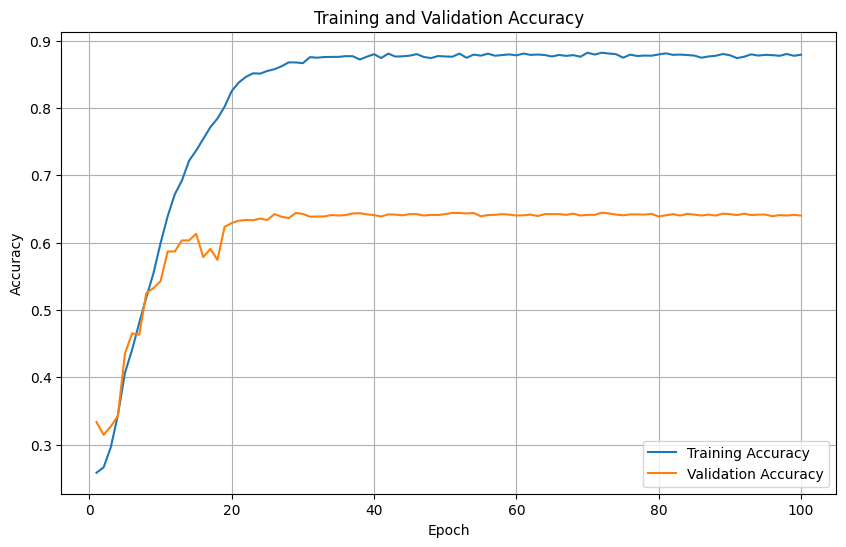

In [10]:
import matplotlib.pyplot as plt
n_epochs = num_epochs * 2
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
utils.test_model(model, test_loader)

Test acc: 0.639


In [12]:
del model
torch.cuda.empty_cache()
gc.collect()

102

# **CNN**

In [13]:
params = utils.learn_hyperparameters(X_train=X_train,
                                     y_train=y_train,
                                     X_valid=X_valid,
                                     y_valid=y_valid,
                                     model_name='CNN',
                                     num_epochs=num_epochs,
                                     trials=num_trials)

[I 2024-03-12 20:08:23,358] A new study created in memory with name: no-name-058dca3b-5a8b-4658-99bd-c85e3c1d2e77


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              Adamax
        Learning Rate:      0.004486159590333669
        Weight Decay:       3.875376418442356e-06
    Model:                  CNN
        Dropout:            0.6209369651104765
        Conv Kernel Size:   5
        Pool Kernel Size:   2
        Depth:              32
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.242, Val loss: 1.376
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.307, Val loss: 1.367
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.274, Val acc: 0.293, Val loss: 1.349
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.318, Val loss: 1.354
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.289, Val acc: 0.291, Val loss: 1.342


[I 2024-03-12 20:08:46,168] Trial 0 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adamax
        Learning Rate:      0.0027874396410662453
        Weight Decay:       7.874362442326075e-05
    Model:                  CNN
        Dropout:            0.7690021885154918
        Conv Kernel Size:   5
        Pool Kernel Size:   4
        Depth:              32
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.214, Val loss: 1.386
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.232, Val loss: 1.370
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.229, Val loss: 1.369
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.214, Val loss: 1.362


[I 2024-03-12 20:09:19,973] Trial 1 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              SGD
        Learning Rate:      0.0013806541715146257
        Weight Decay:       9.785625312471516e-05
        Momentum:           0.8418568124995027
    Model:                  CNN
        Dropout:            0.6609784914349801
        Conv Kernel Size:   6
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.243, Val loss: 1.365
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.243, Val loss: 1.365
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.234, Val loss: 1.374
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.231, Val loss: 1.371


[I 2024-03-12 20:10:00,203] Trial 2 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              SGD
        Learning Rate:      0.0005488246398912736
        Weight Decay:       6.684096291805934e-05
        Momentum:           0.9516686632313012
    Model:                  CNN
        Dropout:            0.6378055171202824
        Conv Kernel Size:   10
        Pool Kernel Size:   3
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.204, Val loss: 1.380
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.223, Val loss: 1.378
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.217, Val loss: 1.379
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-12 20:10:23,936] Trial 3 pruned. 


Train acc: 0.264, Val acc: 0.227, Val loss: 1.394
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              NAdam
        Learning Rate:      0.00015081884465613675
        Weight Decay:       1.0025148640124619e-05
    Model:                  CNN
        Dropout:            0.7738623796054618
        Conv Kernel Size:   6
        Pool Kernel Size:   4
        Depth:              32
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.268, Val loss: 1.335
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.231, Val loss: 1.350
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.228, Val loss: 1.365
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.202, Val loss: 1.369


[I 2024-03-12 20:10:50,255] Trial 4 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adamax
        Learning Rate:      0.0026481764129688665
        Weight Decay:       3.047432739393999e-06
    Model:                  CNN
        Dropout:            0.6747116953521046
        Conv Kernel Size:   5
        Pool Kernel Size:   3
        Depth:              64
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.253, Val loss: 1.366
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.244, Val loss: 1.360
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.269, Val acc: 0.270, Val loss: 1.367
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.275, Val acc: 0.273, Val loss: 1.356


[I 2024-03-12 20:11:22,439] Trial 5 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              NAdam
        Learning Rate:      0.000558647857188445
        Weight Decay:       3.616948395206469e-06
    Model:                  CNN
        Dropout:            0.5484896315670771
        Conv Kernel Size:   5
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.270, Val acc: 0.334, Val loss: 1.321
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.290, Val acc: 0.365, Val loss: 1.337
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.314, Val acc: 0.357, Val loss: 1.320
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.327, Val acc: 0.362, Val loss: 1.276
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.364, Val loss: 1.272
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.355, Val acc: 0.375, Val loss: 1.249
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.373, Val loss: 1.238
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.371, Val loss: 1.212
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.378, Val loss: 1.234
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.358, Val loss: 1.209
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.426, Val acc: 0.359, Val loss: 1.216
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.349, Val loss: 1.205
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.461, Val acc: 0.363, Val loss: 1.189
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.358, Val loss: 1.237
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.377, Val loss: 1.243
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.512, Val acc: 0.354, Val loss: 1.199
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.525, Val acc: 0.343, Val loss: 1.216
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.542, Val acc: 0.353, Val loss: 1.237
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.555, Val acc: 0.346, Val loss: 1.243
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.337, Val loss: 1.255
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.582, Val acc: 0.335, Val loss: 1.260
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.590, Val acc: 0.334, Val loss: 1.287
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.346, Val loss: 1.216
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.613, Val acc: 0.335, Val loss: 1.227
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.626, Val acc: 0.340, Val loss: 1.243
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.645, Val acc: 0.334, Val loss: 1.254
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.339, Val loss: 1.257
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.650, Val acc: 0.341, Val loss: 1.251
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.653, Val acc: 0.342, Val loss: 1.253
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.650, Val acc: 0.340, Val loss: 1.261
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.658, Val acc: 0.341, Val loss: 1.260
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.658, Val acc: 0.343, Val loss: 1.267
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.664, Val acc: 0.343, Val loss: 1.255
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.665, Val acc: 0.345, Val loss: 1.276
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.667, Val acc: 0.344, Val loss: 1.262
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.672, Val acc: 0.346, Val loss: 1.265
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.267
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.346, Val loss: 1.268
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.347, Val loss: 1.267
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.668, Val acc: 0.344, Val loss: 1.269
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.266
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.271
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.344, Val loss: 1.268
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.668, Val acc: 0.342, Val loss: 1.273
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.343, Val loss: 1.272
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.344, Val loss: 1.271
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.669, Val acc: 0.343, Val loss: 1.270
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.342, Val loss: 1.272
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.343, Val loss: 1.273
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.342, Val loss: 1.270


[I 2024-03-12 20:19:24,339] Trial 6 finished with value: 0.37783199548721313 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.000558647857188445, 'weight_decay': 3.616948395206469e-06, 'momentum': 0.9207378361050504, 'dropout': 0.5484896315670771, 'kernel': 5, 'pool_kernel': 2, 'depth': 128, 'hidden_dims': 128}. Best is trial 6 with value: 0.37783199548721313.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              Adamax
        Learning Rate:      0.00012344638533509747
        Weight Decay:       1.0509316642012239e-05
    Model:                  CNN
        Dropout:            0.650645663407675
        Conv Kernel Size:   6
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.253, Val acc: 0.301, Val loss: 1.408
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.300, Val loss: 1.387
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.250, Val loss: 1.387
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.255, Val loss: 1.374


[I 2024-03-12 20:20:08,183] Trial 7 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.00011723981283068849
        Weight Decay:       6.3257044333619555e-06
    Model:                  CNN
        Dropout:            0.7348037791112954
        Conv Kernel Size:   10
        Pool Kernel Size:   2
        Depth:              128
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.261, Val loss: 1.374
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.253, Val acc: 0.235, Val loss: 1.349
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.244, Val loss: 1.357
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.237, Val loss: 1.359


[I 2024-03-12 20:20:54,024] Trial 8 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.000478383070504675
        Weight Decay:       2.4342743424654264e-06
        Momentum:           0.8158682806080406
    Model:                  CNN
        Dropout:            0.5669080661380475
        Conv Kernel Size:   8
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.283, Val loss: 1.344
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.299, Val acc: 0.307, Val loss: 1.342
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.321, Val acc: 0.302, Val loss: 1.315
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.370, Val loss: 1.288
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.360, Val acc: 0.346, Val loss: 1.278
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.364, Val loss: 1.236
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.393, Val acc: 0.344, Val loss: 1.257
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.362, Val loss: 1.244
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.366, Val loss: 1.245
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.344, Val loss: 1.330
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.458, Val acc: 0.367, Val loss: 1.279
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.473, Val acc: 0.352, Val loss: 1.248
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.484, Val acc: 0.362, Val loss: 1.241
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.353, Val loss: 1.237
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.508, Val acc: 0.343, Val loss: 1.213
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.363, Val loss: 1.231
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.533, Val acc: 0.360, Val loss: 1.246
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.543, Val acc: 0.349, Val loss: 1.235
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.550, Val acc: 0.343, Val loss: 1.227
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.559, Val acc: 0.345, Val loss: 1.231
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.568, Val acc: 0.347, Val loss: 1.223
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.352, Val loss: 1.256
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.584, Val acc: 0.340, Val loss: 1.203
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.353, Val loss: 1.192
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.592, Val acc: 0.355, Val loss: 1.211
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.337, Val loss: 1.205
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.343, Val loss: 1.140
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.618, Val acc: 0.342, Val loss: 1.205
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.346, Val loss: 1.176
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.342, Val loss: 1.162
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.343, Val loss: 1.116
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.333, Val loss: 1.165
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.642, Val acc: 0.334, Val loss: 1.191
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.345, Val loss: 1.186
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.645, Val acc: 0.351, Val loss: 1.198
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.655, Val acc: 0.348, Val loss: 1.197
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.653, Val acc: 0.344, Val loss: 1.208
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.661, Val acc: 0.346, Val loss: 1.235
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.662, Val acc: 0.351, Val loss: 1.203
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.346, Val loss: 1.252
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.667, Val acc: 0.332, Val loss: 1.261
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.672, Val acc: 0.343, Val loss: 1.268
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.344, Val loss: 1.266
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.688, Val acc: 0.346, Val loss: 1.277
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.690, Val acc: 0.345, Val loss: 1.271
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.695, Val acc: 0.344, Val loss: 1.282
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.695, Val acc: 0.340, Val loss: 1.292
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.698, Val acc: 0.344, Val loss: 1.279
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.695, Val acc: 0.343, Val loss: 1.269
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.339, Val loss: 1.267


[I 2024-03-12 20:25:18,858] Trial 9 finished with value: 0.36981526017189026 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.000478383070504675, 'weight_decay': 2.4342743424654264e-06, 'momentum': 0.8158682806080406, 'dropout': 0.5669080661380475, 'kernel': 8, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 128}. Best is trial 6 with value: 0.37783199548721313.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              NAdam
        Learning Rate:      0.009961464453279703
        Weight Decay:       1.0521530213914173e-06
    Model:                  CNN
        Dropout:            0.5349444690998638
        Conv Kernel Size:   8
        Pool Kernel Size:   3
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.280, Val acc: 0.317, Val loss: 1.336
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.330, Val loss: 1.299
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.371, Val acc: 0.318, Val loss: 1.295
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.401, Val acc: 0.347, Val loss: 1.271
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.344, Val loss: 1.291
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.487, Val acc: 0.336, Val loss: 1.293
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.518, Val acc: 0.365, Val loss: 1.229
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.564, Val acc: 0.344, Val loss: 1.276
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.611, Val acc: 0.335, Val loss: 1.310
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.652, Val acc: 0.345, Val loss: 1.385
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.687, Val acc: 0.354, Val loss: 1.452
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.712, Val acc: 0.338, Val loss: 1.325
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.740, Val acc: 0.348, Val loss: 1.417
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.364, Val loss: 1.515
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.366, Val loss: 1.410
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.795, Val acc: 0.335, Val loss: 1.301
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.811, Val acc: 0.361, Val loss: 1.361
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.339, Val loss: 1.394
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.356, Val loss: 1.426
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.352, Val loss: 1.457
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.352, Val loss: 1.517
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.357, Val loss: 1.551
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.354, Val loss: 1.560
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.356, Val loss: 1.672
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.349, Val loss: 1.691
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.353, Val loss: 1.663
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.359, Val loss: 1.673
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.355, Val loss: 1.726
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.907, Val acc: 0.359, Val loss: 1.680
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.909, Val acc: 0.359, Val loss: 1.680
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.362, Val loss: 1.692
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.360, Val loss: 1.702
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.910, Val acc: 0.359, Val loss: 1.695
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.356, Val loss: 1.700
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.358, Val loss: 1.700
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.911, Val acc: 0.358, Val loss: 1.708
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.359, Val loss: 1.723
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.357, Val loss: 1.730
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.357, Val loss: 1.710
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.356, Val loss: 1.733
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.360, Val loss: 1.745
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.358, Val loss: 1.740
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.359, Val loss: 1.727
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.913, Val acc: 0.358, Val loss: 1.738
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.914, Val acc: 0.357, Val loss: 1.732
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.358, Val loss: 1.725
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.359, Val loss: 1.726
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.912, Val acc: 0.362, Val loss: 1.732
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.359, Val loss: 1.726
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.360, Val loss: 1.721


[I 2024-03-12 20:34:12,698] Trial 10 finished with value: 0.36632972955703735 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.009961464453279703, 'weight_decay': 1.0521530213914173e-06, 'momentum': 0.9087340983567924, 'dropout': 0.5349444690998638, 'kernel': 8, 'pool_kernel': 3, 'depth': 128, 'hidden_dims': 256}. Best is trial 6 with value: 0.37783199548721313.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.0004613482731169536
        Weight Decay:       1.6327469206869846e-06
        Momentum:           0.9063951862808258
    Model:                  CNN
        Dropout:            0.5361115512391246
        Conv Kernel Size:   8
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.234, Val loss: 1.370
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.289, Val acc: 0.307, Val loss: 1.318
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.310, Val loss: 1.306
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.344, Val acc: 0.341, Val loss: 1.261
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.366, Val acc: 0.328, Val loss: 1.188
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.398, Val acc: 0.341, Val loss: 1.166
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.385, Val loss: 1.106
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.352, Val loss: 1.108
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.357, Val loss: 1.209
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.483, Val acc: 0.341, Val loss: 1.171
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.504, Val acc: 0.375, Val loss: 1.148
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.526, Val acc: 0.348, Val loss: 1.147
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.366, Val loss: 1.173
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.550, Val acc: 0.347, Val loss: 1.179
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.571, Val acc: 0.348, Val loss: 1.146
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.368, Val loss: 1.102
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.587, Val acc: 0.330, Val loss: 1.173
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.599, Val acc: 0.344, Val loss: 1.115
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.609, Val acc: 0.356, Val loss: 1.127
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.358, Val loss: 1.065
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.347, Val loss: 1.159
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.633, Val acc: 0.351, Val loss: 1.105
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.363, Val loss: 1.142
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.369, Val loss: 1.231
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.654, Val acc: 0.347, Val loss: 1.198
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.356, Val loss: 1.213
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.667, Val acc: 0.347, Val loss: 1.189
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.358, Val loss: 1.136
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.356, Val loss: 1.190
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.685, Val acc: 0.349, Val loss: 1.177
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.355, Val loss: 1.202
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.703, Val acc: 0.347, Val loss: 1.221
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.713, Val acc: 0.347, Val loss: 1.221
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.342, Val loss: 1.215
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.342, Val loss: 1.231
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.348, Val loss: 1.223
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.344, Val loss: 1.216
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.726, Val acc: 0.345, Val loss: 1.226
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.728, Val acc: 0.346, Val loss: 1.242
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.729, Val acc: 0.346, Val loss: 1.248
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.347, Val loss: 1.231
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.733, Val acc: 0.349, Val loss: 1.233
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.348, Val loss: 1.237
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.739, Val acc: 0.349, Val loss: 1.237
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.733, Val acc: 0.349, Val loss: 1.239
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.738, Val acc: 0.350, Val loss: 1.240
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.348, Val loss: 1.238
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.739, Val acc: 0.351, Val loss: 1.239
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.350, Val loss: 1.242
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.351, Val loss: 1.241


[I 2024-03-12 20:38:44,739] Trial 11 finished with value: 0.38515162467956543 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0004613482731169536, 'weight_decay': 1.6327469206869846e-06, 'momentum': 0.9063951862808258, 'dropout': 0.5361115512391246, 'kernel': 8, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 128}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.000367129058615726
        Weight Decay:       1.0938391390583381e-06
        Momentum:           0.9120411837908572
    Model:                  CNN
        Dropout:            0.5075467950689494
        Conv Kernel Size:   9
        Pool Kernel Size:   2
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.272, Val acc: 0.288, Val loss: 1.343
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.298, Val acc: 0.305, Val loss: 1.341
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.324, Val acc: 0.333, Val loss: 1.285
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.352, Val acc: 0.348, Val loss: 1.260
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.383, Val acc: 0.358, Val loss: 1.201
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.340, Val loss: 1.192
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.369, Val loss: 1.124
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.490, Val acc: 0.372, Val loss: 1.230
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.344, Val loss: 1.180
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.547, Val acc: 0.334, Val loss: 1.117
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.370, Val loss: 1.125
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.591, Val acc: 0.360, Val loss: 1.141
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.349, Val loss: 1.137
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.342, Val loss: 1.200
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.348, Val loss: 1.159
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.342, Val loss: 1.256
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.352, Val loss: 1.228
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.331, Val loss: 1.281
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.696, Val acc: 0.322, Val loss: 1.287
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.711, Val acc: 0.346, Val loss: 1.389
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.711, Val acc: 0.334, Val loss: 1.360
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.730, Val acc: 0.341, Val loss: 1.322
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.339, Val loss: 1.361
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.348, Val loss: 1.342
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.344, Val loss: 1.345
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.756, Val acc: 0.346, Val loss: 1.354
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.340, Val loss: 1.374
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.762, Val acc: 0.343, Val loss: 1.364
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.341, Val loss: 1.370
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.767, Val acc: 0.341, Val loss: 1.353
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.335, Val loss: 1.376
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.341, Val loss: 1.351
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.342, Val loss: 1.357
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.343, Val loss: 1.359
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.774, Val acc: 0.343, Val loss: 1.359
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.766, Val acc: 0.341, Val loss: 1.364
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.777, Val acc: 0.341, Val loss: 1.358
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.339, Val loss: 1.363
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.341, Val loss: 1.371
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.339, Val loss: 1.368
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.341, Val loss: 1.369
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.782, Val acc: 0.341, Val loss: 1.367
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.780, Val acc: 0.342, Val loss: 1.366
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.341, Val loss: 1.367
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.342, Val loss: 1.372
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.777, Val acc: 0.341, Val loss: 1.371
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.781, Val acc: 0.341, Val loss: 1.367
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.339, Val loss: 1.368
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.340, Val loss: 1.367
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.340, Val loss: 1.370


[I 2024-03-12 20:43:12,720] Trial 12 finished with value: 0.3715580403804779 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.000367129058615726, 'weight_decay': 1.0938391390583381e-06, 'momentum': 0.9120411837908572, 'dropout': 0.5075467950689494, 'kernel': 9, 'pool_kernel': 2, 'depth': 64, 'hidden_dims': 128}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.0009841173371589744
        Weight Decay:       2.29090489669216e-05
        Momentum:           0.8778800417092884
    Model:                  CNN
        Dropout:            0.5795799774974825
        Conv Kernel Size:   7
        Pool Kernel Size:   3
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.255, Val loss: 1.369
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.297, Val acc: 0.282, Val loss: 1.325
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.317, Val acc: 0.281, Val loss: 1.283
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.332, Val loss: 1.253
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.347, Val loss: 1.277
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.351, Val acc: 0.313, Val loss: 1.287
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.363, Val acc: 0.348, Val loss: 1.276
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.361, Val acc: 0.320, Val loss: 1.255
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.367, Val acc: 0.345, Val loss: 1.260
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.374, Val acc: 0.346, Val loss: 1.252
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.376, Val acc: 0.328, Val loss: 1.237
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.379, Val acc: 0.331, Val loss: 1.224
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.382, Val acc: 0.345, Val loss: 1.162
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.318, Val loss: 1.255
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.392, Val acc: 0.361, Val loss: 1.251
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.392, Val acc: 0.336, Val loss: 1.171
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.334, Val loss: 1.220
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.328, Val loss: 1.183
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.408, Val acc: 0.351, Val loss: 1.220
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.413, Val acc: 0.368, Val loss: 1.184
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.364, Val loss: 1.211
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.353, Val loss: 1.182
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.372, Val loss: 1.144
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.427, Val acc: 0.367, Val loss: 1.084
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.432, Val acc: 0.369, Val loss: 1.152
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.437, Val acc: 0.361, Val loss: 1.175
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.366, Val loss: 1.042
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.354, Val loss: 1.102
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.350, Val loss: 1.120
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.441, Val acc: 0.375, Val loss: 1.115
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.371, Val loss: 1.070
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.353, Val loss: 1.176
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.363, Val loss: 1.138
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.336, Val loss: 1.106
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.356, Val loss: 1.135
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.459, Val acc: 0.345, Val loss: 1.076
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.362, Val loss: 1.210
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.460, Val acc: 0.351, Val loss: 1.100
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.359, Val loss: 1.080
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.354, Val loss: 1.053
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.364, Val loss: 1.055
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.509, Val acc: 0.365, Val loss: 1.032
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.517, Val acc: 0.366, Val loss: 1.032
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.531, Val acc: 0.371, Val loss: 1.054
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.535, Val acc: 0.374, Val loss: 1.019
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.368, Val loss: 1.044
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.548, Val acc: 0.383, Val loss: 1.048
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.551, Val acc: 0.367, Val loss: 1.028
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.562, Val acc: 0.377, Val loss: 1.038
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.568, Val acc: 0.369, Val loss: 1.024


[I 2024-03-12 20:50:56,611] Trial 13 finished with value: 0.3834088444709778 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009841173371589744, 'weight_decay': 2.29090489669216e-05, 'momentum': 0.8778800417092884, 'dropout': 0.5795799774974825, 'kernel': 7, 'pool_kernel': 3, 'depth': 128, 'hidden_dims': 128}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             128
    Hidden Dimensions:      256
    Optimizer:              RMSprop
        Learning Rate:      0.0010865079008100223
        Weight Decay:       2.6443985871119005e-05
        Momentum:           0.8718775514934595
    Model:                  CNN
        Dropout:            0.588143794249866
        Conv Kernel Size:   7
        Pool Kernel Size:   3
        Depth:              64
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.215, Val loss: 1.358
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.260, Val loss: 1.419
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.303, Val acc: 0.283, Val loss: 1.341
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.326, Val acc: 0.318, Val loss: 1.332
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.311, Val loss: 1.283
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.346, Val acc: 0.348, Val loss: 1.299
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.356, Val acc: 0.329, Val loss: 1.262
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.358, Val acc: 0.318, Val loss: 1.316
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.323, Val loss: 1.273
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.344, Val loss: 1.217
Epoch 11


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.389, Val acc: 0.318, Val loss: 1.287
Epoch 12


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.334, Val loss: 1.222
Epoch 13


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.337, Val loss: 1.186
Epoch 14


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.343, Val loss: 1.202
Epoch 15


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.374, Val loss: 1.158
Epoch 16


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.432, Val acc: 0.373, Val loss: 1.189
Epoch 17


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.443, Val acc: 0.346, Val loss: 1.124
Epoch 18


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.338, Val loss: 1.095
Epoch 19


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.336, Val loss: 1.094
Epoch 20


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.354, Val loss: 1.075
Epoch 21


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.470, Val acc: 0.352, Val loss: 1.132
Epoch 22


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.477, Val acc: 0.344, Val loss: 1.114
Epoch 23


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.480, Val acc: 0.348, Val loss: 1.105
Epoch 24


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.485, Val acc: 0.363, Val loss: 1.080
Epoch 25


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.348, Val loss: 1.026
Epoch 26


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.493, Val acc: 0.323, Val loss: 1.036
Epoch 27


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.324, Val loss: 1.128
Epoch 28


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.496, Val acc: 0.359, Val loss: 1.077
Epoch 29


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.502, Val acc: 0.368, Val loss: 1.030
Epoch 30


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.509, Val acc: 0.338, Val loss: 1.041
Epoch 31


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.513, Val acc: 0.350, Val loss: 1.060
Epoch 32


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.512, Val acc: 0.356, Val loss: 1.148
Epoch 33


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.347, Val loss: 1.070
Epoch 34


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.360, Val loss: 1.116
Epoch 35


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.345, Val loss: 1.078
Epoch 36


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.349, Val loss: 1.106
Epoch 37


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.554, Val acc: 0.362, Val loss: 1.061
Epoch 38


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.363, Val loss: 1.057
Epoch 39


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.586, Val acc: 0.359, Val loss: 1.082
Epoch 40


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.593, Val acc: 0.362, Val loss: 1.081
Epoch 41


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.597, Val acc: 0.356, Val loss: 1.068
Epoch 42


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.608, Val acc: 0.358, Val loss: 1.083
Epoch 43


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.614, Val acc: 0.358, Val loss: 1.052
Epoch 44


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.618, Val acc: 0.348, Val loss: 1.040
Epoch 45


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.352, Val loss: 1.046
Epoch 46


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.628, Val acc: 0.356, Val loss: 1.050
Epoch 47


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.634, Val acc: 0.357, Val loss: 1.038
Epoch 48


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.635, Val acc: 0.355, Val loss: 1.036
Epoch 49


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.354, Val loss: 1.040
Epoch 50


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.640, Val acc: 0.351, Val loss: 1.044


[I 2024-03-12 20:54:28,868] Trial 14 finished with value: 0.37364935874938965 and parameters: {'batch_size': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010865079008100223, 'weight_decay': 2.6443985871119005e-05, 'momentum': 0.8718775514934595, 'dropout': 0.588143794249866, 'kernel': 7, 'pool_kernel': 3, 'depth': 64, 'hidden_dims': 256}. Best is trial 11 with value: 0.38515162467956543.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.00027785398446778285
        Weight Decay:       2.489372802978191e-05
        Momentum:           0.87231941552011
    Model:                  CNN
        Dropout:            0.5883169404585995
        Conv Kernel Size:   7
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.288, Val acc: 0.289, Val loss: 1.293
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.336, Val acc: 0.353, Val loss: 1.284
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.370, Val loss: 1.299
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.394, Val acc: 0.386, Val loss: 1.234
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.405, Val loss: 1.233
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.398, Val loss: 1.189
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.468, Val acc: 0.406, Val loss: 1.185
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.490, Val acc: 0.411, Val loss: 1.153
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.412, Val loss: 1.255
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.542, Val acc: 0.402, Val loss: 1.238
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.411, Val loss: 1.250
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.591, Val acc: 0.420, Val loss: 1.216
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.618, Val acc: 0.416, Val loss: 1.147
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.432, Val loss: 1.247
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.412, Val loss: 1.283
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.430, Val loss: 1.163
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.416, Val loss: 1.160
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.407, Val loss: 1.164
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.434, Val loss: 1.203
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.712, Val acc: 0.426, Val loss: 1.187
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.416, Val loss: 1.241
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.421, Val loss: 1.165
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.422, Val loss: 1.238
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.747, Val acc: 0.417, Val loss: 1.220
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.425, Val loss: 1.247
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.422, Val loss: 1.255
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.422, Val loss: 1.298
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.786, Val acc: 0.428, Val loss: 1.256
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.790, Val acc: 0.422, Val loss: 1.258
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.795, Val acc: 0.421, Val loss: 1.266
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.797, Val acc: 0.426, Val loss: 1.268
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.804, Val acc: 0.425, Val loss: 1.256
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.424, Val loss: 1.301
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.419, Val loss: 1.269
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.812, Val acc: 0.420, Val loss: 1.259
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.417, Val loss: 1.251
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.815, Val acc: 0.418, Val loss: 1.262
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.813, Val acc: 0.418, Val loss: 1.282
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.419, Val loss: 1.275
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.420, Val loss: 1.268
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.811, Val acc: 0.421, Val loss: 1.277
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.417, Val loss: 1.268
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.420, Val loss: 1.277
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.425, Val loss: 1.269
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.419, Val loss: 1.278
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.420, Val loss: 1.286
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.819, Val acc: 0.420, Val loss: 1.284
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.418, Val loss: 1.286
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.420, Val loss: 1.288
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.419, Val loss: 1.284


[I 2024-03-12 21:02:03,989] Trial 15 finished with value: 0.434297651052475 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00027785398446778285, 'weight_decay': 2.489372802978191e-05, 'momentum': 0.87231941552011, 'dropout': 0.5883169404585995, 'kernel': 7, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 128}. Best is trial 15 with value: 0.434297651052475.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              RMSprop
        Learning Rate:      0.0002603533315376711
        Weight Decay:       2.4819945979567538e-05
        Momentum:           0.9317222911598132
    Model:                  CNN
        Dropout:            0.500194910225066
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              64
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.337, Val acc: 0.425, Val loss: 1.251
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.410, Val acc: 0.428, Val loss: 1.158
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.455, Val loss: 1.155
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.494, Val loss: 1.089
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.468, Val loss: 1.040
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.607, Val acc: 0.507, Val loss: 0.974
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.637, Val acc: 0.481, Val loss: 1.028
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.659, Val acc: 0.477, Val loss: 1.050
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.501, Val loss: 0.995
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.692, Val acc: 0.511, Val loss: 0.980
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.492, Val loss: 1.020
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.722, Val acc: 0.512, Val loss: 1.012
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.731, Val acc: 0.518, Val loss: 0.962
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.489, Val loss: 1.043
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.753, Val acc: 0.498, Val loss: 1.026
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.763, Val acc: 0.482, Val loss: 1.094
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.773, Val acc: 0.485, Val loss: 1.202
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.775, Val acc: 0.494, Val loss: 1.020
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.518, Val loss: 1.043
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.516, Val loss: 1.133
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.499, Val loss: 1.109
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.512, Val loss: 1.169
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.802, Val acc: 0.503, Val loss: 1.242
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.801, Val acc: 0.501, Val loss: 1.140
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.823, Val acc: 0.506, Val loss: 1.171
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.831, Val acc: 0.505, Val loss: 1.164
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.511, Val loss: 1.153
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.510, Val loss: 1.140
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.515, Val loss: 1.132
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.511, Val loss: 1.172
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.515, Val loss: 1.189
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.509, Val loss: 1.182
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.507, Val loss: 1.175
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.512, Val loss: 1.182
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.515, Val loss: 1.196
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.880, Val acc: 0.510, Val loss: 1.202
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.520, Val loss: 1.196
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.508, Val loss: 1.211
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.513, Val loss: 1.211
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.876, Val acc: 0.511, Val loss: 1.206
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.512, Val loss: 1.212
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.513, Val loss: 1.205
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.516, Val loss: 1.201
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.509, Val loss: 1.231
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.511, Val loss: 1.221
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.511, Val loss: 1.215
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.510, Val loss: 1.211
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.518, Val loss: 1.197
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.508, Val loss: 1.215
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.516, Val loss: 1.221


[I 2024-03-12 21:07:28,880] Trial 16 finished with value: 0.5196932554244995 and parameters: {'batch_size': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0002603533315376711, 'weight_decay': 2.4819945979567538e-05, 'momentum': 0.9317222911598132, 'dropout': 0.500194910225066, 'kernel': 9, 'pool_kernel': 4, 'depth': 64, 'hidden_dims': 128}. Best is trial 16 with value: 0.5196932554244995.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.0002574772806421799
        Weight Decay:       2.789168280062458e-05
    Model:                  CNN
        Dropout:            0.50672242686817
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.304, Val acc: 0.364, Val loss: 1.345
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.383, Val acc: 0.385, Val loss: 1.197
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.426, Val loss: 1.173
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.477, Val acc: 0.413, Val loss: 1.182
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.449, Val loss: 1.128
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.561, Val acc: 0.447, Val loss: 1.184
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.595, Val acc: 0.477, Val loss: 1.144
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.630, Val acc: 0.503, Val loss: 1.133
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.482, Val loss: 1.170
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.694, Val acc: 0.484, Val loss: 1.250
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.489, Val loss: 1.286
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.754, Val acc: 0.501, Val loss: 1.179
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.777, Val acc: 0.508, Val loss: 1.150
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.800, Val acc: 0.507, Val loss: 1.192
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.493, Val loss: 1.290
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.508, Val loss: 1.224
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.511, Val loss: 1.175
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.860, Val acc: 0.513, Val loss: 1.210
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.509, Val loss: 1.199
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.519, Val loss: 1.186
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.508, Val loss: 1.226
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.518, Val loss: 1.195
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.506, Val loss: 1.225
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.515, Val loss: 1.214
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.517, Val loss: 1.223
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.524, Val loss: 1.207
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.519, Val loss: 1.229
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.520, Val loss: 1.205
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.515, Val loss: 1.194
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.517, Val loss: 1.217
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.516, Val loss: 1.201
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.520, Val loss: 1.207
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.520, Val loss: 1.201
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.519, Val loss: 1.212
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.516, Val loss: 1.230
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.519, Val loss: 1.211
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.514, Val loss: 1.228
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.513, Val loss: 1.217
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.894, Val acc: 0.518, Val loss: 1.188
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.510, Val loss: 1.224
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.518, Val loss: 1.212
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.514, Val loss: 1.209
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.514, Val loss: 1.220
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.518, Val loss: 1.214
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.898, Val acc: 0.517, Val loss: 1.219
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.899, Val acc: 0.517, Val loss: 1.198
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.514, Val loss: 1.220
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.897, Val acc: 0.515, Val loss: 1.212
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.519, Val loss: 1.213
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.900, Val acc: 0.518, Val loss: 1.199


[I 2024-03-12 21:16:00,426] Trial 17 finished with value: 0.523875892162323 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0002574772806421799, 'weight_decay': 2.789168280062458e-05, 'momentum': 0.9325243109242702, 'dropout': 0.50672242686817, 'kernel': 9, 'pool_kernel': 4, 'depth': 128, 'hidden_dims': 128}. Best is trial 17 with value: 0.523875892162323.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      256
    Optimizer:              Adam
        Learning Rate:      0.00020621133194425697
        Weight Decay:       4.616682651045325e-05
    Model:                  CNN
        Dropout:            0.5072440916932877
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              64
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.280, Val acc: 0.289, Val loss: 1.324
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.329, Val acc: 0.343, Val loss: 1.251
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.375, Val loss: 1.226
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.386, Val loss: 1.182
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.400, Val loss: 1.154
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.436, Val loss: 1.211
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.504, Val acc: 0.448, Val loss: 1.165
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.527, Val acc: 0.438, Val loss: 1.182
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.544, Val acc: 0.450, Val loss: 1.183
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.563, Val acc: 0.476, Val loss: 1.172
Epoch 11


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.581, Val acc: 0.471, Val loss: 1.115
Epoch 12


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.484, Val loss: 1.143
Epoch 13


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.619, Val acc: 0.509, Val loss: 1.147
Epoch 14


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.633, Val acc: 0.496, Val loss: 1.201
Epoch 15


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.649, Val acc: 0.509, Val loss: 1.134
Epoch 16


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.504, Val loss: 1.050
Epoch 17


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.684, Val acc: 0.502, Val loss: 1.085
Epoch 18


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.506, Val loss: 1.046
Epoch 19


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.713, Val acc: 0.499, Val loss: 0.999
Epoch 20


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.732, Val acc: 0.495, Val loss: 1.050
Epoch 21


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.743, Val acc: 0.490, Val loss: 1.092
Epoch 22


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.754, Val acc: 0.501, Val loss: 1.031
Epoch 23


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.766, Val acc: 0.495, Val loss: 1.071
Epoch 24


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.779, Val acc: 0.478, Val loss: 1.102
Epoch 25


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.788, Val acc: 0.468, Val loss: 1.120
Epoch 26


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.798, Val acc: 0.503, Val loss: 1.023
Epoch 27


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.497, Val loss: 1.038
Epoch 28


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.811, Val acc: 0.497, Val loss: 1.080
Epoch 29


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.822, Val acc: 0.492, Val loss: 1.086
Epoch 30


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.829, Val acc: 0.475, Val loss: 1.092
Epoch 31


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.483, Val loss: 1.084
Epoch 32


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.844, Val acc: 0.479, Val loss: 1.085
Epoch 33


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.485, Val loss: 1.062
Epoch 34


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.845, Val acc: 0.481, Val loss: 1.063
Epoch 35


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.484, Val loss: 1.036
Epoch 36


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.481, Val loss: 1.082
Epoch 37


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.481, Val loss: 1.061
Epoch 38


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.480, Val loss: 1.033
Epoch 39


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.860, Val acc: 0.478, Val loss: 1.065
Epoch 40


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.482, Val loss: 1.093
Epoch 41


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.484, Val loss: 1.100
Epoch 42


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.482, Val loss: 1.096
Epoch 43


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.474, Val loss: 1.103
Epoch 44


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.478, Val loss: 1.092
Epoch 45


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.475, Val loss: 1.085
Epoch 46


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.474, Val loss: 1.080
Epoch 47


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.476, Val loss: 1.088
Epoch 48


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.477, Val loss: 1.095
Epoch 49


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.481, Val loss: 1.092
Epoch 50


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.481, Val loss: 1.082


[I 2024-03-12 21:21:37,084] Trial 18 finished with value: 0.5092366337776184 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.00020621133194425697, 'weight_decay': 4.616682651045325e-05, 'momentum': 0.9832035911325139, 'dropout': 0.5072440916932877, 'kernel': 9, 'pool_kernel': 4, 'depth': 64, 'hidden_dims': 256}. Best is trial 17 with value: 0.523875892162323.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.0002135893677570713
        Weight Decay:       1.7548901940097026e-05
    Model:                  CNN
        Dropout:            0.6953929684758691
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              32
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.214, Val loss: 1.399
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.214, Val loss: 1.417
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.214, Val loss: 1.387
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.275, Val acc: 0.214, Val loss: 1.384


[I 2024-03-12 21:22:02,089] Trial 19 pruned. 


Number of finished trials: 20
Best trial:
    Validation Accuracy: 0.523875892162323
    Learned Hyperparameters
    ------------------------
    Batch Size:             64
    Hidden Dimensions:      128
    Optimizer:              Adam
        Learning Rate:      0.0002574772806421799
        Weight Decay:       2.789168280062458e-05
    Model:                  CNN
        Dropout:            0.50672242686817
        Conv Kernel Size:   9
        Pool Kernel Size:   4
        Depth:              128


In [14]:
model = cnn.CNN(num_classes=4,
              hidden_dims=params.get('hidden_dims'),
              dropout=params.get('dropout'),
              kernel=params.get('kernel'),
              pool_kernel=params.get('pool_kernel'),
              depth=params.get('depth'))

criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 128, 392]            --
│    └─Conv1d: 2-1                       [64, 128, 392]            25,472
│    └─ReLU: 2-2                         [64, 128, 392]            --
│    └─BatchNorm1d: 2-3                  [64, 128, 392]            256
│    └─Dropout: 2-4                      [64, 128, 392]            --
├─Sequential: 1-2                        [64, 256, 1, 96]          --
│    └─Conv2d: 2-5                       [64, 256, 1, 384]         295,168
│    └─ELU: 2-6                          [64, 256, 1, 384]         --
│    └─BatchNorm2d: 2-7                  [64, 256, 1, 384]         512
│    └─MaxPool2d: 2-8                    [64, 256, 1, 96]          --
│    └─Dropout: 2-9                      [64, 256, 1, 96]          --
├─Sequential: 1-3                        [64, 512, 22]             --
│   

In [15]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=num_epochs * 2,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.284, Val acc: 0.300, Val loss: 1.314
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.394, Val loss: 1.233
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.386, Val loss: 1.199
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.401, Val loss: 1.200
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.374, Val loss: 1.213
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.471, Val acc: 0.398, Val loss: 1.215
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.406, Val loss: 1.196
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.396, Val loss: 1.232
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.540, Val acc: 0.414, Val loss: 1.292
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.563, Val acc: 0.424, Val loss: 1.244
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.590, Val acc: 0.460, Val loss: 1.187
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.610, Val acc: 0.440, Val loss: 1.234
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.450, Val loss: 1.212
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.651, Val acc: 0.435, Val loss: 1.296
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.468, Val loss: 1.230
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.699, Val acc: 0.441, Val loss: 1.261
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.720, Val acc: 0.444, Val loss: 1.350
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.742, Val acc: 0.446, Val loss: 1.361
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.768, Val acc: 0.444, Val loss: 1.449
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.480, Val loss: 1.284
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.796, Val acc: 0.461, Val loss: 1.368
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.814, Val acc: 0.466, Val loss: 1.365
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.831, Val acc: 0.464, Val loss: 1.347
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.462, Val loss: 1.325
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.842, Val acc: 0.460, Val loss: 1.344
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.847, Val acc: 0.457, Val loss: 1.339
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.458, Val loss: 1.356
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.461, Val loss: 1.331
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.458, Val loss: 1.331
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.462, Val loss: 1.353
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.861, Val acc: 0.461, Val loss: 1.325
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.456, Val loss: 1.346
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.458, Val loss: 1.345
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.460, Val loss: 1.343
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.458, Val loss: 1.355
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.457, Val loss: 1.351
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.459, Val loss: 1.342
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.458, Val loss: 1.345
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.345
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.461, Val loss: 1.347
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.353
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.459, Val loss: 1.351
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.457, Val loss: 1.350
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.346
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.345
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.458, Val loss: 1.345
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.336
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.347
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.457, Val loss: 1.355
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.340
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.337
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.344
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.459, Val loss: 1.333
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.454, Val loss: 1.358
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.349
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.460, Val loss: 1.349
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.340
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.457, Val loss: 1.347
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.460, Val loss: 1.340
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.354
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.457, Val loss: 1.349
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.460, Val loss: 1.347
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.459, Val loss: 1.339
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.459, Val loss: 1.349
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.459, Val loss: 1.340
Epoch 66


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.345
Epoch 67


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.352
Epoch 68


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.871, Val acc: 0.461, Val loss: 1.348
Epoch 69


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.343
Epoch 70


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.351
Epoch 71


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.873, Val acc: 0.457, Val loss: 1.345
Epoch 72


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.461, Val loss: 1.345
Epoch 73


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.352
Epoch 74


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.457, Val loss: 1.348
Epoch 75


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.461, Val loss: 1.341
Epoch 76


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.348
Epoch 77


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.462, Val loss: 1.346
Epoch 78


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.457, Val loss: 1.358
Epoch 79


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.872, Val acc: 0.459, Val loss: 1.351
Epoch 80


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.345
Epoch 81


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.353
Epoch 82


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.456, Val loss: 1.347
Epoch 83


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.457, Val loss: 1.352
Epoch 84


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.460, Val loss: 1.343
Epoch 85


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.458, Val loss: 1.343
Epoch 86


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.459, Val loss: 1.343
Epoch 87


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.457, Val loss: 1.346
Epoch 88


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.458, Val loss: 1.342
Epoch 89


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.456, Val loss: 1.344
Epoch 90


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.457, Val loss: 1.346
Epoch 91


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.456, Val loss: 1.350
Epoch 92


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.457, Val loss: 1.356
Epoch 93


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.456, Val loss: 1.348
Epoch 94


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.455, Val loss: 1.353
Epoch 95


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.459, Val loss: 1.347
Epoch 96


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.866, Val acc: 0.458, Val loss: 1.349
Epoch 97


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.457, Val loss: 1.348
Epoch 98


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.459, Val loss: 1.339
Epoch 99


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.867, Val acc: 0.460, Val loss: 1.335
Epoch 100


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.869, Val acc: 0.461, Val loss: 1.345


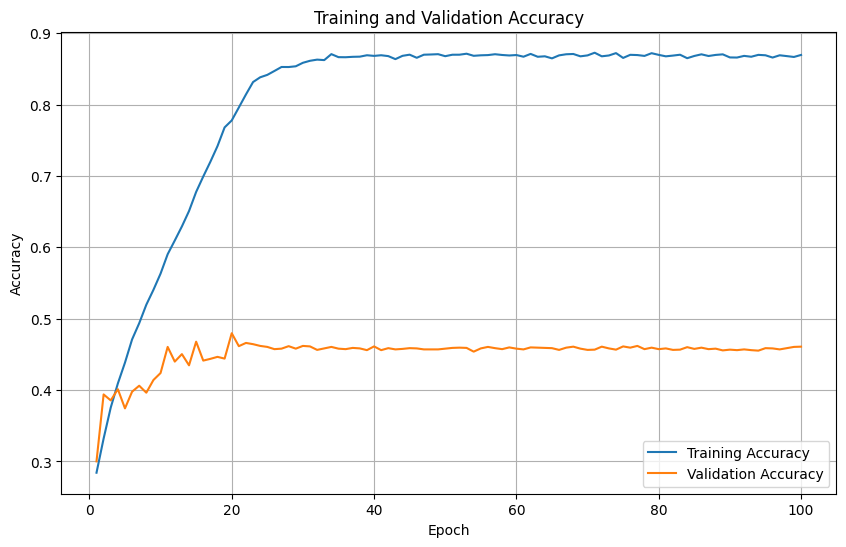

In [16]:
import matplotlib.pyplot as plt
n_epochs = num_epochs * 2
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
utils.test_model(model, test_loader)
end_time = time.time()

Test acc: 0.447


In [18]:
del model
torch.cuda.empty_cache()
gc.collect()

3471

# **CNNLSTM**

In [10]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [7]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=5,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=32):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=depth,
                      out_channels=depth,
                      kernel_size=kernel * 2,
                      stride=stride,
                      padding=padding + 1),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth,
                      out_channels=depth,
                      kernel_size=kernel * 4,
                      stride=stride,
                      padding=padding + 3),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth,
                      out_channels=depth * 4,
                      kernel_size=kernel * 4,
                      stride=stride,
                      padding=padding + 5),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout)
        )

        self.lstm1 = nn.LSTM(input_size=depth * 4,
                             hidden_size=hidden_dims // 2,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=hidden_dims,
                             hidden_size=hidden_dims // 2,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=hidden_dims,
                                      out_features=hidden_dims // 2)),
            TimeDistributed(nn.ELU()),
            TimeDistributed(nn.BatchNorm1d(hidden_dims // 2)),
            TimeDistributed(nn.Dropout(dropout)),

            TimeDistributed(nn.Linear(in_features=hidden_dims // 2,
                                      out_features=hidden_dims // 4)),
            TimeDistributed(nn.ELU()),
            TimeDistributed(nn.BatchNorm1d(hidden_dims // 4)),
            TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=hidden_dims // 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.td(x)
        x = x[:, -1, :]
        x = self.dense(x)
        return F.log_softmax(x, dim=1)




In [8]:
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

NameError: name 'TimeDistributed' is not defined

In [ ]:
params = utils.learn_hyperparameters(X_train=X_train,
                                     y_train=y_train,
                                     X_valid=X_valid,
                                     y_valid=y_valid,
                                     model_name='CNNLSTM',
                                     num_epochs=num_epochs,
                                     trials=num_trials)

In [ ]:
model = clstm.CNNLSTM(num_classes=4,
              hidden_dims=params.get('hidden_dims'),
              dropout=params.get('dropout'),
              kernel=params.get('kernel'),
              pool_kernel=params.get('pool_kernel'),
              depth=params.get('depth'))

criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [56]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [57]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=num_epochs * 2,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.307, Val loss: 1.416
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.415, Val loss: 1.294
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.418, Val acc: 0.395, Val loss: 1.265
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.445, Val acc: 0.416, Val loss: 1.244
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.462, Val acc: 0.426, Val loss: 1.229
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.421, Val loss: 1.228
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.443, Val loss: 1.207
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.428, Val loss: 1.224
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.447, Val loss: 1.221
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.507, Val acc: 0.449, Val loss: 1.176
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.521, Val acc: 0.443, Val loss: 1.179
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.527, Val acc: 0.454, Val loss: 1.198
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.459, Val loss: 1.153
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.466, Val loss: 1.195
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.538, Val acc: 0.467, Val loss: 1.193
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.540, Val acc: 0.465, Val loss: 1.183
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.545, Val acc: 0.447, Val loss: 1.260
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.549, Val acc: 0.475, Val loss: 1.212
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.552, Val acc: 0.496, Val loss: 1.155
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.560, Val acc: 0.487, Val loss: 1.128
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.559, Val acc: 0.471, Val loss: 1.089
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.565, Val acc: 0.460, Val loss: 1.178
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.564, Val acc: 0.480, Val loss: 1.067
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.571, Val acc: 0.471, Val loss: 1.114
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.569, Val acc: 0.471, Val loss: 1.157
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.483, Val loss: 1.112
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.577, Val acc: 0.497, Val loss: 1.074
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.485, Val loss: 1.201
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.585, Val acc: 0.491, Val loss: 1.199
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.581, Val acc: 0.479, Val loss: 1.182
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.584, Val acc: 0.479, Val loss: 1.183
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.495, Val loss: 1.078
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.497, Val loss: 1.080
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.596, Val acc: 0.488, Val loss: 1.160
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.597, Val acc: 0.507, Val loss: 1.097
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.605, Val acc: 0.512, Val loss: 1.091
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.613, Val acc: 0.510, Val loss: 1.090
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.611, Val acc: 0.508, Val loss: 1.113
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.615, Val acc: 0.517, Val loss: 1.106
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.617, Val acc: 0.510, Val loss: 1.109
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.619, Val acc: 0.511, Val loss: 1.107
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.620, Val acc: 0.514, Val loss: 1.127
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.616, Val acc: 0.512, Val loss: 1.111
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.514, Val loss: 1.108
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.512, Val loss: 1.104
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.514, Val loss: 1.109
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.626, Val acc: 0.516, Val loss: 1.108
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.514, Val loss: 1.105
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.514, Val loss: 1.114
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.517, Val loss: 1.115
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.513, Val loss: 1.114
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.630, Val acc: 0.516, Val loss: 1.111
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.517, Val loss: 1.111
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.517, Val loss: 1.115
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.518, Val loss: 1.113
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.517, Val loss: 1.117
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.515, Val loss: 1.116
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.622, Val acc: 0.517, Val loss: 1.113
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.514, Val loss: 1.112
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.518, Val loss: 1.112
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.625, Val acc: 0.515, Val loss: 1.114
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.627, Val acc: 0.519, Val loss: 1.113
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.516, Val loss: 1.116
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.623, Val acc: 0.517, Val loss: 1.109
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
n_epochs = num_epochs * 2
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
utils.test_model(model, test_loader)
end_time = time.time()

In [ ]:
del model
torch.cuda.empty_cache()
gc.collect()

In [ ]:
end_time = time.time()
print('time i will never get back:')
hours = (end_time - start_time) // 3600
minutes = ((end_time - start_time) % 3600) // 60
seconds = (end_time - start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

# other

## cnn

In [7]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [8]:
class CNN(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=10,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 2),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 2, out_features=depth),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout),
        )

        self.dense = nn.Linear(in_features=depth,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        # print(x.shape)
        # x = self.td(x)
        x = x[:, -1, :]
        x = self.nd(x)
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [9]:
batch_size = 64
torchinfo.summary(CNN(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 391]             --
│    └─Conv1d: 2-1                       [64, 25, 391]             5,525
│    └─ReLU: 2-2                         [64, 25, 391]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 391]             50
│    └─Dropout: 2-4                      [64, 25, 391]             --
├─Sequential: 1-2                        [64, 50, 1, 122]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 367]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 367]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 367]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 122]          --
│    └─Dropout: 2-9                      [64, 50, 1, 122]          --
├─Sequential: 1-3                        [64, 100, 38]             --
│    └─

In [10]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [11]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.288, Val loss: 1.379
Epoch 2


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.292, Val acc: 0.307, Val loss: 1.338
Epoch 3


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.350, Val acc: 0.346, Val loss: 1.283
Epoch 4


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.407, Val loss: 1.262
Epoch 5


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.429, Val loss: 1.270
Epoch 6


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.383, Val loss: 1.275
Epoch 7


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.411, Val loss: 1.242
Epoch 8


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.393, Val loss: 1.250
Epoch 9


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.432, Val loss: 1.212
Epoch 10


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.459, Val acc: 0.422, Val loss: 1.203
Epoch 11


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.473, Val acc: 0.444, Val loss: 1.240
Epoch 12


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.453, Val loss: 1.195
Epoch 13


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.495, Val acc: 0.454, Val loss: 1.162
Epoch 14


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.498, Val acc: 0.455, Val loss: 1.145
Epoch 15


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.513, Val acc: 0.464, Val loss: 1.131
Epoch 16


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.520, Val acc: 0.455, Val loss: 1.109
Epoch 17


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.528, Val acc: 0.459, Val loss: 1.102
Epoch 18


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.475, Val loss: 1.103
Epoch 19


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.538, Val acc: 0.485, Val loss: 1.123
Epoch 20


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.543, Val acc: 0.500, Val loss: 1.130
Epoch 21


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.552, Val acc: 0.485, Val loss: 1.105
Epoch 22


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.566, Val acc: 0.504, Val loss: 1.121
Epoch 23


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.569, Val acc: 0.529, Val loss: 1.113
Epoch 24


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.576, Val acc: 0.513, Val loss: 1.148
Epoch 25


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.585, Val acc: 0.521, Val loss: 1.102
Epoch 26


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.597, Val acc: 0.545, Val loss: 1.071
Epoch 27


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.613, Val acc: 0.583, Val loss: 1.074
Epoch 28


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.621, Val acc: 0.575, Val loss: 1.046
Epoch 29


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.632, Val acc: 0.559, Val loss: 1.061
Epoch 30


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.553, Val loss: 1.101
Epoch 31


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.641, Val acc: 0.603, Val loss: 0.946
Epoch 32


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.650, Val acc: 0.575, Val loss: 1.032
Epoch 33


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.656, Val acc: 0.594, Val loss: 1.008
Epoch 34


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.597, Val loss: 1.008
Epoch 35


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.664, Val acc: 0.598, Val loss: 0.982
Epoch 36


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.661, Val acc: 0.598, Val loss: 1.005
Epoch 37


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.670, Val acc: 0.589, Val loss: 1.041
Epoch 38


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.603, Val loss: 0.980
Epoch 39


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.599, Val loss: 0.966
Epoch 40


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.607, Val loss: 1.004
Epoch 41


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.593, Val loss: 0.979
Epoch 42


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.684, Val acc: 0.591, Val loss: 0.989
Epoch 43


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.694, Val acc: 0.598, Val loss: 0.995
Epoch 44


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.707, Val acc: 0.602, Val loss: 0.981
Epoch 45


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.709, Val acc: 0.607, Val loss: 0.970
Epoch 46


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.605, Val loss: 0.970
Epoch 47


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.605, Val loss: 0.981
Epoch 48


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.717, Val acc: 0.605, Val loss: 0.988
Epoch 49


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.604, Val loss: 1.003
Epoch 50


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.721, Val acc: 0.611, Val loss: 0.987


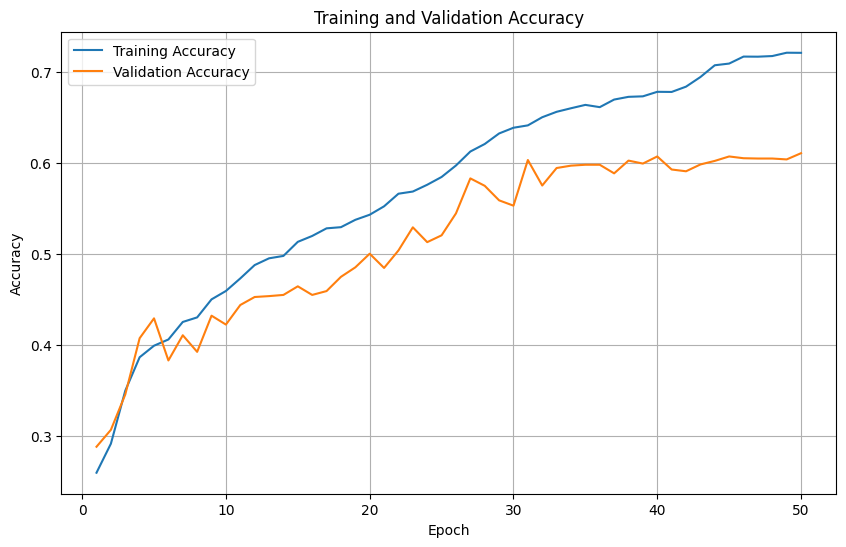

In [12]:
import matplotlib.pyplot as plt
n_epochs = 50
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
utils.test_model(model, test_loader)
end_time = time.time()

Test acc: 0.585


## shallow cnn

In [14]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [27]:
class Shallow(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=20,
                 stride=1,
                 padding=0,
                 pool_kernel=60,
                 time_bins=400,
                 channels=22,
                 depth=50):
        super(Shallow, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 8,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 8),
            nn.AvgPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout),
            nn.Tanh()
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 2),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 2, out_features=depth),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout),
        )

        self.dense = nn.Linear(in_features=depth,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x = self.dense(x)

        return F.log_softmax(x, dim=1)

In [28]:
batch_size = 64
torchinfo.summary(Shallow(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
Shallow                                  [64, 4]                   --
├─Sequential: 1-1                        [64, 50, 381]             --
│    └─Conv1d: 2-1                       [64, 50, 381]             22,050
│    └─ReLU: 2-2                         [64, 50, 381]             --
│    └─BatchNorm1d: 2-3                  [64, 50, 381]             100
│    └─Dropout: 2-4                      [64, 50, 381]             --
├─Sequential: 1-2                        [64, 400, 1, 5]           --
│    └─Conv2d: 2-5                       [64, 400, 1, 332]         1,000,400
│    └─ELU: 2-6                          [64, 400, 1, 332]         --
│    └─BatchNorm2d: 2-7                  [64, 400, 1, 332]         800
│    └─AvgPool2d: 2-8                    [64, 400, 1, 5]           --
│    └─Dropout: 2-9                      [64, 400, 1, 5]           --
│    └─Tanh: 2-10                        [64, 400, 1, 5]           --
├─

In [29]:
model = Shallow().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [30]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.267, Val acc: 0.275, Val loss: 1.382
Epoch 2


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.306, Val loss: 1.378
Epoch 3


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.318, Val loss: 1.304
Epoch 4


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.344, Val acc: 0.314, Val loss: 1.304
Epoch 5


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.361, Val acc: 0.307, Val loss: 1.292
Epoch 6


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.372, Val acc: 0.336, Val loss: 1.259
Epoch 7


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.339, Val loss: 1.283
Epoch 8


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.397, Val acc: 0.349, Val loss: 1.256
Epoch 9


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.408, Val acc: 0.363, Val loss: 1.253
Epoch 10


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.399, Val loss: 1.181
Epoch 11


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.433, Val acc: 0.374, Val loss: 1.231
Epoch 12


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.385, Val loss: 1.185
Epoch 13


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.425, Val loss: 1.241
Epoch 14


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.461, Val acc: 0.416, Val loss: 1.171
Epoch 15


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.479, Val acc: 0.415, Val loss: 1.150
Epoch 16


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.489, Val acc: 0.421, Val loss: 1.147
Epoch 17


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.499, Val acc: 0.407, Val loss: 1.228
Epoch 18


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.511, Val acc: 0.415, Val loss: 1.192
Epoch 19


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.530, Val acc: 0.395, Val loss: 1.231
Epoch 20


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.545, Val acc: 0.430, Val loss: 1.223
Epoch 21


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.562, Val acc: 0.406, Val loss: 1.209
Epoch 22


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.587, Val acc: 0.412, Val loss: 1.199
Epoch 23


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.605, Val acc: 0.433, Val loss: 1.137
Epoch 24


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.626, Val acc: 0.419, Val loss: 1.280
Epoch 25


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.651, Val acc: 0.439, Val loss: 1.117
Epoch 26


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.371, Val loss: 1.231
Epoch 27


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.685, Val acc: 0.400, Val loss: 1.256
Epoch 28


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.703, Val acc: 0.392, Val loss: 1.227
Epoch 29


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.424, Val loss: 1.261
Epoch 30


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.728, Val acc: 0.393, Val loss: 1.306
Epoch 31


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.745, Val acc: 0.392, Val loss: 1.326
Epoch 32


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.755, Val acc: 0.442, Val loss: 1.320
Epoch 33


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.764, Val acc: 0.381, Val loss: 1.358
Epoch 34


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.772, Val acc: 0.393, Val loss: 1.439
Epoch 35


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.780, Val acc: 0.428, Val loss: 1.371
Epoch 36


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.787, Val acc: 0.402, Val loss: 1.406
Epoch 37


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.416, Val loss: 1.284
Epoch 38


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.837, Val acc: 0.410, Val loss: 1.276
Epoch 39


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.410, Val loss: 1.285
Epoch 40


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.416, Val loss: 1.299
Epoch 41


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.411, Val loss: 1.298
Epoch 42


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.863, Val acc: 0.412, Val loss: 1.295
Epoch 43


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.408, Val loss: 1.319
Epoch 44


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.870, Val acc: 0.421, Val loss: 1.297
Epoch 45


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.409, Val loss: 1.277
Epoch 46


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.418, Val loss: 1.304
Epoch 47


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.416, Val loss: 1.282
Epoch 48


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.415, Val loss: 1.277
Epoch 49


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.883, Val acc: 0.414, Val loss: 1.293
Epoch 50


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.418, Val loss: 1.285


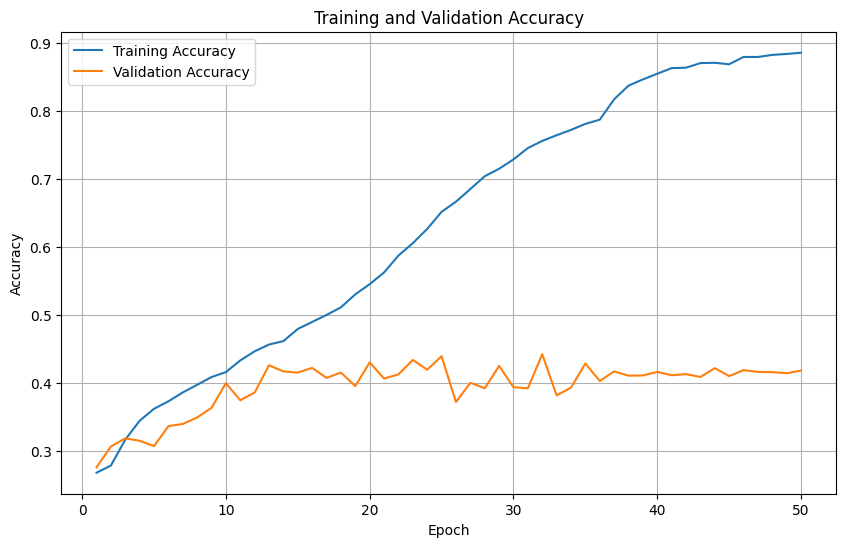

In [32]:
import matplotlib.pyplot as plt
n_epochs = 50
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
utils.test_model(model, test_loader)
end_time = time.time()

Test acc: 0.327


## cnn lstm

In [34]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [35]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=5,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=32):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )


        self.lstm1 = nn.LSTM(input_size=depth * 8,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=depth * 8,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ELU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            TimeDistributed(nn.ELU()),
            TimeDistributed(nn.BatchNorm1d(depth * 2)),
            TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=depth * 2, out_features=num_classes)

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 2),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 2, out_features=depth),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.td(x)
        x = x[:, -1, :]
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [36]:
batch_size = 64
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [64, 4]                   43,680
├─Sequential: 1-1                        [64, 32, 198]             --
│    └─Conv1d: 2-1                       [64, 32, 198]             3,552
│    └─ReLU: 2-2                         [64, 32, 198]             --
│    └─BatchNorm1d: 2-3                  [64, 32, 198]             64
│    └─Dropout: 2-4                      [64, 32, 198]             --
├─Sequential: 1-2                        [64, 64, 1, 42]           --
│    └─Conv2d: 2-5                       [64, 64, 1, 84]           65,600
│    └─ELU: 2-6                          [64, 64, 1, 84]           --
│    └─BatchNorm2d: 2-7                  [64, 64, 1, 84]           128
│    └─MaxPool2d: 2-8                    [64, 64, 1, 42]           --
│    └─Dropout: 2-9                      [64, 64, 1, 42]           --
├─Sequential: 1-3                        [64, 128, 10]             --
│  

In [37]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [38]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.356, Val loss: 1.349
Epoch 2


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.383, Val acc: 0.399, Val loss: 1.312
Epoch 3


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.421, Val acc: 0.446, Val loss: 1.269
Epoch 4


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.450, Val loss: 1.251
Epoch 5


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.482, Val loss: 1.183
Epoch 6


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.500, Val acc: 0.466, Val loss: 1.189
Epoch 7


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.523, Val acc: 0.472, Val loss: 1.174
Epoch 8


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.537, Val acc: 0.470, Val loss: 1.181
Epoch 9


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.550, Val acc: 0.461, Val loss: 1.139
Epoch 10


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.562, Val acc: 0.466, Val loss: 1.208
Epoch 11


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.572, Val acc: 0.452, Val loss: 1.154
Epoch 12


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.586, Val acc: 0.478, Val loss: 1.202
Epoch 13


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.481, Val loss: 1.154
Epoch 14


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.596, Val acc: 0.447, Val loss: 1.274
Epoch 15


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.608, Val acc: 0.495, Val loss: 1.159
Epoch 16


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.615, Val acc: 0.483, Val loss: 1.227
Epoch 17


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.620, Val acc: 0.494, Val loss: 1.187
Epoch 18


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.629, Val acc: 0.507, Val loss: 1.238
Epoch 19


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.634, Val acc: 0.499, Val loss: 1.201
Epoch 20


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.642, Val acc: 0.497, Val loss: 1.115
Epoch 21


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.652, Val acc: 0.446, Val loss: 1.312
Epoch 22


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.648, Val acc: 0.489, Val loss: 1.193
Epoch 23


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.655, Val acc: 0.500, Val loss: 1.191
Epoch 24


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.659, Val acc: 0.513, Val loss: 1.198
Epoch 25


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.513, Val loss: 1.210
Epoch 26


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.503, Val loss: 1.237
Epoch 27


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.502, Val loss: 1.223
Epoch 28


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.514, Val loss: 1.102
Epoch 29


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.464, Val loss: 1.360
Epoch 30


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.518, Val loss: 1.159
Epoch 31


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.521, Val loss: 1.134
Epoch 32


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.690, Val acc: 0.522, Val loss: 1.122
Epoch 33


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.693, Val acc: 0.543, Val loss: 1.147
Epoch 34


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.699, Val acc: 0.512, Val loss: 1.112
Epoch 35


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.702, Val acc: 0.524, Val loss: 1.143
Epoch 36


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.702, Val acc: 0.536, Val loss: 1.085
Epoch 37


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.698, Val acc: 0.542, Val loss: 1.122
Epoch 38


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.708, Val acc: 0.520, Val loss: 1.145
Epoch 39


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.707, Val acc: 0.552, Val loss: 1.132
Epoch 40


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.709, Val acc: 0.528, Val loss: 1.117
Epoch 41


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.713, Val acc: 0.517, Val loss: 1.147
Epoch 42


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.531, Val loss: 1.171
Epoch 43


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.711, Val acc: 0.511, Val loss: 1.190
Epoch 44


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.716, Val acc: 0.568, Val loss: 1.086
Epoch 45


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.720, Val acc: 0.552, Val loss: 1.158
Epoch 46


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.559, Val loss: 1.085
Epoch 47


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.722, Val acc: 0.555, Val loss: 1.088
Epoch 48


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.718, Val acc: 0.566, Val loss: 1.042
Epoch 49


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.725, Val acc: 0.543, Val loss: 1.102
Epoch 50


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.719, Val acc: 0.542, Val loss: 1.147


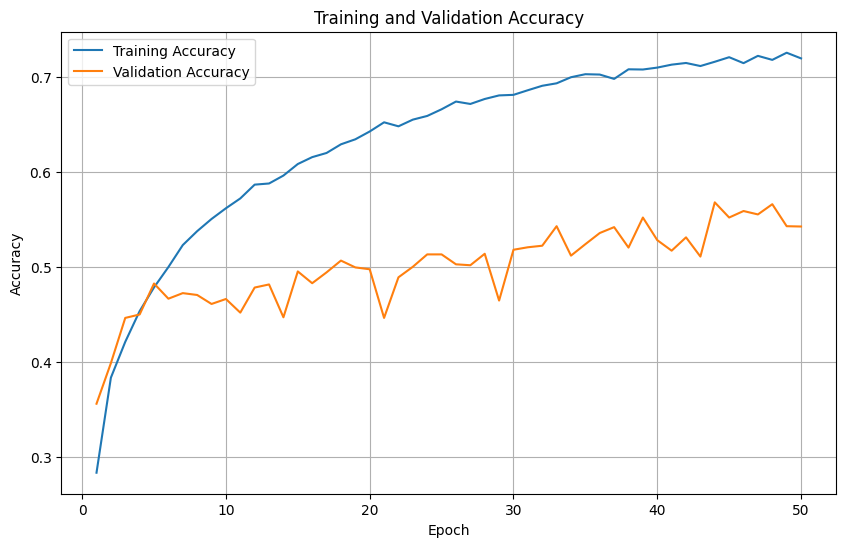

In [39]:
import matplotlib.pyplot as plt
n_epochs = 50
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
utils.test_model(model, test_loader)
end_time = time.time()

Test acc: 0.558


## gru

In [41]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [42]:
class GRU(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=128,
                 num_layers=2,
                 dropout=0.5,
                 kernel=7,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=64):
        super(GRU, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 2),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 2, out_features=depth),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout),
        )

        self.gru = nn.GRU(input_size=depth * 8,
                           hidden_size=depth * 4,
                           num_layers=num_layers,
                           bias=True,
                           batch_first=True,
                           bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 2)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 2, out_features=depth)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth)),
            TimeDistributed(nn.Dropout(dropout)),
        )
        self.dense = nn.Linear(in_features=depth, out_features=num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x, _ = self.gru(x)
        x = self.td(x)
        x = x[:, -1, :]
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [43]:
batch_size = 64
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [64, 4]                   173,376
├─Sequential: 1-1                        [64, 64, 394]             --
│    └─Conv1d: 2-1                       [64, 64, 394]             9,920
│    └─ReLU: 2-2                         [64, 64, 394]             --
│    └─BatchNorm1d: 2-3                  [64, 64, 394]             128
│    └─Dropout: 2-4                      [64, 64, 394]             --
├─Sequential: 1-2                        [64, 128, 1, 110]         --
│    └─Conv2d: 2-5                       [64, 128, 1, 331]         524,416
│    └─ELU: 2-6                          [64, 128, 1, 331]         --
│    └─BatchNorm2d: 2-7                  [64, 128, 1, 331]         256
│    └─MaxPool2d: 2-8                    [64, 128, 1, 110]         --
│    └─Dropout: 2-9                      [64, 128, 1, 110]         --
├─Sequential: 1-3                        [64, 256, 35]             --


In [44]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
train_accuracies, val_accuracies = utils.train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=50,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.274, Val acc: 0.232, Val loss: 1.433
Epoch 2


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.362, Val acc: 0.313, Val loss: 1.313
Epoch 3


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.436, Val acc: 0.413, Val loss: 1.127
Epoch 4


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.481, Val loss: 1.119
Epoch 5


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.538, Val acc: 0.513, Val loss: 1.081
Epoch 6


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.603, Val acc: 0.528, Val loss: 1.082
Epoch 7


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.641, Val acc: 0.564, Val loss: 0.932
Epoch 8


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.597, Val loss: 0.949
Epoch 9


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.700, Val acc: 0.609, Val loss: 0.925
Epoch 10


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.723, Val acc: 0.593, Val loss: 0.916
Epoch 11


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.747, Val acc: 0.619, Val loss: 0.933
Epoch 12


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.759, Val acc: 0.596, Val loss: 0.927
Epoch 13


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.781, Val acc: 0.561, Val loss: 1.189
Epoch 14


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.581, Val loss: 1.236
Epoch 15


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.805, Val acc: 0.643, Val loss: 0.900
Epoch 16


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.818, Val acc: 0.604, Val loss: 0.877
Epoch 17


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.829, Val acc: 0.599, Val loss: 1.199
Epoch 18


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.599, Val loss: 1.099
Epoch 19


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.846, Val acc: 0.603, Val loss: 1.096
Epoch 20


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.849, Val acc: 0.576, Val loss: 1.061
Epoch 21


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.568, Val loss: 1.312
Epoch 22


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.616, Val loss: 1.105
Epoch 23


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.864, Val acc: 0.569, Val loss: 1.008
Epoch 24


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.865, Val acc: 0.571, Val loss: 1.077
Epoch 25


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.868, Val acc: 0.548, Val loss: 1.149
Epoch 26


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.614, Val loss: 0.849
Epoch 27


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.875, Val acc: 0.584, Val loss: 0.832
Epoch 28


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.877, Val acc: 0.560, Val loss: 0.929
Epoch 29


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.549, Val loss: 1.132
Epoch 30


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.881, Val acc: 0.571, Val loss: 1.043
Epoch 31


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.560, Val loss: 1.173
Epoch 32


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.618, Val loss: 0.888
Epoch 33


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.574, Val loss: 1.002
Epoch 34


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.595, Val loss: 1.109
Epoch 35


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.531, Val loss: 1.251
Epoch 36


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.586, Val loss: 0.982
Epoch 37


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.893, Val acc: 0.591, Val loss: 1.008
Epoch 38


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.891, Val acc: 0.604, Val loss: 1.184
Epoch 39


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.923, Val acc: 0.616, Val loss: 1.048
Epoch 40


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.937, Val acc: 0.609, Val loss: 1.051
Epoch 41


  0%|          | 0/137 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.610, Val loss: 1.071
Epoch 42


  0%|          | 0/137 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
n_epochs = 50
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
utils.test_model(model, test_loader)
end_time = time.time()

In [ ]:
print('time i will never get back:')
hours = (end_time - start_time) // 3600
minutes = ((end_time - start_time) % 3600) // 60
seconds = (end_time - start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')